<a href="https://colab.research.google.com/github/silvern00n/tetris-rl/blob/main/%D7%A4%D7%A8%D7%95%D7%99%D7%99%D7%A7%D7%98_%D7%92%D7%9E%D7%A8_%D7%99%22%D7%91_%D7%92%D7%99%D7%A8%D7%A1%D7%94_%D7%90%D7%97%D7%AA_%D7%9C%D7%A4%D7%A0%D7%99_%D7%94%D7%90%D7%97%D7%A8%D7%95%D7%A0%D7%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div dir = rtl>


---
#**טטריס לימוד חיזוק**
---
פרוייקט גמר תומר לופו 2025  

<div dir = rtl>

# (1) אתחול והכנות

In [1]:
print("hello world")

hello world


In [2]:
# ── Standard Library ───────────────────────────────
import os
import sys
import random
import pickle
import time
from collections import deque, namedtuple
from itertools import count

# ── Third-Party Libraries ───────────────────────────
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import pygame as pg
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from IPython.display import display, HTML
print("import successful")

import successful


In [3]:
python_version = sys.version_info
print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {python_version.major}.{python_version.minor}.{python_version.micro}")

PyTorch version: 2.6.0+cu124
Python version: 3.11.12


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")

Using device: cpu


In [5]:
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDNN Version: {torch.backends.cudnn.version()}")
print(f"CUDNN is available: {torch.backends.cudnn.is_available()}")

CUDA Version: 12.4
CUDNN Version: 90300
CUDNN is available: True


In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("mounted")

Mounted at /content/drive
mounted


In [7]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

In [8]:
project_path = '/content/drive/My Drive/tetris_game'
sys.path.append(project_path)

from tetris import Tetris
from block import Block
from tetromino import Tetromino
from tetris_settings import *
from tetris_settings import stage_params
from app import App
from menu import Menu

font_path = '/content/drive/My Drive/tetris_game/FREAKSOFNATUREMASSIVE.ttf'
globals()['FONT_PATH'] = font_path

# Display imported components
print("Successfully imported Tetris game components:")
print(f"- Game board dimensions: {FIELD_W}x{FIELD_H}")
print(f"- Available Tetromino types: {list(TETROMINOES.keys())}")
print(f"- Game states: {GAME_STATES}")


⚠️ Custom font not found — using system fallback.
Successfully imported Tetris game components:
- Game board dimensions: 10x20
- Available Tetromino types: ['T', 'O', 'J', 'L', 'I', 'S', 'Z']
- Game states: {'MENU': 0, 'PLAYING': 1, 'GAME_OVER': 2}


<div dir = rtl>

# (2) סביבת המשחק

<div dir = rtl>

הקוד מגדיר מעטפת (Wrapper) עבור משחק טטריס שמשתמשת בפורמט של Gym כדי לאפשר למידת חיזוק. המעטפת מאפשרת לתרגם פעולה למיקום וסיבוב, לאתחל את מצב המשחק, לחשב תכונות (features) מתקדמות מהלוח (כמו חורים, מעבר בין מצבים, wells ועוד), ומיישמת מערכת תגמול מורכבת הכוללת shaping מבוסס פונקציית פוטנציאל, בונוסים על הישרדות וקומבו, ועונשים על לוח בעייתי. הקוד כולל גם יכולות רינדור לאנליזה גרפית ואופציה למצב ללא רינדור לאימון מהיר.



In [9]:
class TetrisWrapper(gym.Env):
    """
    A wrapper for the Tetris game compatible with OpenAI Gym.
    Designed for fast training with optional graphical rendering.
    """

    def __init__(self, render_mode=None, stage=5):
        """
        Initializes the environment and Tetris game for a specific stage.
        """
        # Define the action space (placement column and rotation)
        self.action_space = self._create_action_space()

        # Launch full app if rendering is requested, else use mock
        if render_mode == "human":
            self.app = App()
            self.has_display = True
        else:
            self.app = self._create_mock_app()
            self.has_display = False

        # Set field dimensions according to stage settings
        self.field_width, self.field_height = STAGE_BOARD_SIZES.get(stage, (10, 20))
        print(f"\nInitializing stage {stage} with board size: {self.field_width}×{self.field_height}")

        # Update global dimensions and app-specific values
        update_field_dimensions(self.field_width, self.field_height)
        self.app.field_width = self.field_width
        self.app.field_height = self.field_height

        # Gamma and initial shaping potential for reward shaping
        self.gamma = 0.999
        self.prev_potential = 0.0

        # Create the Tetris game instance
        self.tetris = Tetris(self.app)

        # Dellacherie heuristic weights for potential-based reward shaping
        self.DELLACHERIE_W = np.array([
            -4.500158825082766,  # aggregate height
            +3.4181268101392694, # complete lines
            -3.2178882868487753, # holes
            -9.348695305445199,  # bumpiness
        ])

        # Observation space shape
        self.observation_space_shape = self._get_state_shape()

        # Game statistics
        self.score = 0
        self.lines_cleared = 0
        self.pieces_placed = 0
        self.game_over = False

    def _create_mock_app(self):
        """Creates a minimal App object for headless (non-rendered) training."""
        mock_app = type('MockApp', (), {
            'game_state': GAME_STATES['PLAYING'],
            'allowed_shapes': list(TETROMINOES.keys()),
            'anim_trigger': True,
            'fast_anim_trigger': True,
            'field_width': 10,
            'field_height': 20,
            'screen': None,
            'set_field_dimensions': lambda self, w, h: update_field_dimensions(w, h)
        })()
        return mock_app

    def _create_action_space(self):
        """
        Generates all possible (column, rotation) combinations for a 10-column board.
        """
        action_space = []
        max_width = 10
        max_rotations = 4

        for column in range(max_width):
            for rotation in range(max_rotations):
                action_space.append((int(column), int(rotation)))
        return action_space

    def _get_state_shape(self):
        """
        Returns the shape of the observation: board + current + next tetromino.
        """
        field_shape = (self.field_height, self.field_width)
        tetromino_shape = (7,)  # One-hot vector for each piece
        return (field_shape, tetromino_shape, tetromino_shape)

    def reset(self, seed=None):
        """
        Resets the environment and returns the initial state.
        """
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            Tetromino.set_seed(seed)

        self.tetris.reset_game()
        self.score = 0
        self.lines_cleared = 0
        self.pieces_placed = 0
        self.game_over = False

        observation = self._get_state()
        return observation, {}

    def _get_state(self):
        """
        Returns the flattened feature vector: board state + one-hot encoded pieces.
        """
        field_array = self.tetris.field_array
        features = self._extract_features(field_array)

        # One-hot encode current piece
        current_piece = np.zeros(7, dtype=np.float32)
        shape_to_idx = {shape: i for i, shape in enumerate(['I', 'O', 'T', 'L', 'J', 'S', 'Z'])}
        if self.tetris.tetromino and hasattr(self.tetris.tetromino, 'shape'):
            current_piece[shape_to_idx[self.tetris.tetromino.shape]] = 1.0

        # One-hot encode next piece
        next_piece = np.zeros(7, dtype=np.float32)
        if self.tetris.next_tetromino and hasattr(self.tetris.next_tetromino, 'shape'):
            next_piece[shape_to_idx[self.tetris.next_tetromino.shape]] = 1.0

        # Final state = features + current_piece + next_piece
        full_state = np.concatenate([features, current_piece, next_piece]).astype(np.float32)
        return full_state, {}, {}

    def _extract_features(self, field_array):
        """
        Extracts numerical features from the board for learning:
        height, holes, bumpiness, transitions, wells, etc.
        """
        heights = self._get_heights()
        max_height = max(heights) if heights else 0
        holes = self._count_holes(heights)
        bumpiness = self._calculate_bumpiness(heights)

        # Calculate wells between columns
        wells = []
        for x in range(self.field_width):
            l = heights[x-1] if x > 0 else self.field_height
            r = heights[x+1] if x < self.field_width-1 else self.field_height
            wells.append(max(0, min(l, r) - heights[x]))

        # Count transitions between filled/empty cells in rows and columns
        row_trans = col_trans = 0
        for y in range(self.field_height):
            filled = 1
            for x in range(self.field_width):
                cell = 1 if field_array[y][x] else 0
                if cell != filled:
                    row_trans += 1
                filled = cell
            if filled == 0:
                row_trans += 1
        for x in range(self.field_width):
            filled = 1
            for y in range(self.field_height):
                cell = 1 if field_array[y][x] else 0
                if cell != filled:
                    col_trans += 1
                filled = cell
            if filled == 0:
                col_trans += 1

        cum_wells = sum(wells)
        eroded_cells = self.tetris.lines_last_step * 10
        diffs = [heights[i] - heights[i+1] for i in range(len(heights)-1)]

        # Final feature vector of 46 dimensions
        features = np.array(
            heights + [max_height, holes, bumpiness] + wells + diffs +
            [row_trans, col_trans, cum_wells, eroded_cells],
            dtype=np.float32
        )
        return features

    def step(self, action):
        """
        Executes the selected action and returns:
        next_state, reward, done, truncated=False, info.
        """
        if self.game_over:
            return self._get_state(), 0.0, True, False, {}

        column, rotation = self.action_space[action]
        self._execute_action(column, rotation)
        reward, lines_cleared = self._calculate_reward()

        self.lines_cleared += lines_cleared
        self.pieces_placed += 1
        self.score = self.tetris.score
        self.game_over = self.tetris.is_game_over()

        observation = self._get_state()
        info = {
            'lines_cleared': lines_cleared,
            'total_lines': self.lines_cleared,
            'pieces_placed': self.pieces_placed,
            'score': self.score
        }
        return observation, reward, self.game_over, False, info

    def _execute_action(self, column, rotation):
        """
        Rotates and moves the tetromino to the desired location, then hard-drops it.
        """
        # Apply rotation
        for _ in range(rotation):
            self.tetris.tetromino.rotate()

        # Move to desired column
        min_x = min(int(block.pos.x) for block in self.tetris.tetromino.blocks)
        move = int(column - min_x)
        direction = 'right' if move > 0 else 'left'
        for _ in range(abs(move)):
            self.tetris.tetromino.move(direction=direction)

        # Hard drop
        while not self.tetris.tetromino.check_landing():
            self.tetris.tetromino.move(direction='down')

        self.tetris.check_tetromino_landing()

    def _phi_state(self, heights, holes, bumpiness, lines):
        """Computes Dellacherie potential Φ(s) for reward shaping."""
        agg_height = sum(heights)
        feats = np.array([agg_height, lines, holes, bumpiness], dtype=np.float32)
        return float(np.dot(self.DELLACHERIE_W, feats))

    def _calculate_reward(self):
        """Combines line reward, shaping, survival and penalties into final reward."""
        lines_cleared = self.tetris.lines_last_step
        line_reward = {0: 0, 1: 40, 2: 100, 3: 300, 4: 1200}[lines_cleared]

        heights = self._get_heights()
        holes = self._count_holes(heights)
        bumpiness = self._calculate_bumpiness(heights)

        potential = self._phi_state(heights, holes, bumpiness, lines_cleared)
        shaping = self.gamma * potential - self.prev_potential
        self.prev_potential = potential

        combo_bonus = min(self.tetris.combo_count * 0.5, 2.0) if lines_cleared else 0
        board_penalty, bonus_near_full = self._evaluate_board_state()
        survival_reward = 0.01
        game_over_penalty = -5.0 if self.tetris.is_game_over() else 0

        total_reward = (
            line_reward * 2 + combo_bonus + bonus_near_full -
            board_penalty + survival_reward + game_over_penalty +
            shaping
        )
        return total_reward, lines_cleared

    def _evaluate_board_state(self):
        """Evaluates penalties for bad board states and bonuses for near-complete rows."""
        penalty = 0.0
        bonus = 0.0

        heights = self._get_heights()
        max_height = max(heights) if heights else 0
        height_penalty = max(0, max_height - self.field_height / 2) * 0.02

        holes = self._count_holes(heights)
        holes_penalty = holes * 0.05

        # Penalize deep holes
        deep_holes_penalty = 0.0
        for x in range(self.field_width):
            column_hole_depth = 0
            seen_block = False
            for y in range(self.field_height):
                if self.tetris.field_array[y][x]:
                    seen_block = True
                elif seen_block:
                    column_hole_depth += 1
            deep_holes_penalty += (column_hole_depth ** 2) * 0.001

        bumpiness = self._calculate_bumpiness(heights)
        bumpiness_penalty = bumpiness * 0.01

        for y in range(self.field_height):
            filled = sum(1 for x in range(self.field_width) if self.tetris.field_array[y][x])
            if filled == self.field_width - 1:
                bonus += 0.5

        penalty = height_penalty + holes_penalty + bumpiness_penalty + deep_holes_penalty
        return penalty, bonus

    def _get_heights(self):
        """Returns the height of each column based on filled cells."""
        heights = []
        for x in range(self.field_width):
            for y in range(self.field_height):
                if self.tetris.field_array[y][x]:
                    heights.append(self.field_height - y)
                    break
            else:
                heights.append(0)
        return heights

    def _count_holes(self, heights):
        """Counts the number of empty cells below filled cells in each column."""
        holes = 0
        for x in range(self.field_width):
            top = self.field_height - heights[x] if x < len(heights) else 0
            for y in range(top + 1, self.field_height):
                if not self.tetris.field_array[y][x]:
                    holes += 1
        return holes

    def _calculate_bumpiness(self, heights):
        """Returns the sum of absolute differences between adjacent column heights."""
        if not heights or len(heights) < 2:
            return 0
        return sum(abs(heights[i] - heights[i+1]) for i in range(len(heights) - 1))

    def render(self):
        """Renders the game window if in human mode."""
        if self.has_display:
            self.app.draw()
            pg.display.flip()

    def close(self):
        """Shuts down the game and closes the display."""
        if self.has_display:
            pg.quit()

    def render_board_as_image(self):
        """
        Converts the board into a color-coded NumPy RGB image for visualization or recording.
        """
        shape_colors = {
            'I': (0, 255, 255), 'O': (255, 255, 0), 'T': (128, 0, 128),
            'S': (0, 255, 0), 'Z': (255, 0, 0), 'J': (0, 0, 255),
            'L': (255, 165, 0), 'default': (200, 200, 200)
        }

        board = np.zeros((self.field_height, self.field_width, 3), dtype=np.uint8)

        for y in range(self.field_height):
            for x in range(self.field_width):
                cell = self.tetris.field_array[y][x]
                if cell:
                    shape = getattr(cell.tetromino, 'shape', 'default') if hasattr(cell, 'tetromino') else 'default'
                    board[y, x] = shape_colors.get(shape, shape_colors['default'])

        return board

<div dir = rtl>

# (4) ארכיטקטורת הרשת

<div dir = rtl>


המודל TetrisDQN הוא רשת עצבית עבור סוכן למידת חיזוק מסוג Dueling DQN, שמתאימה במיוחד למשחקים כמו טטריס. הרשת מחלקת את החיזוי לשני זרמים:

Value stream שמעריך את ערך המצב (V).

Advantage stream שמעריך את היתרון של כל פעולה (A) ביחס לממוצע.
שני הזרמים מחוברים לפי הנוסחה Q(s,a) = V(s) + (A(s,a) - mean(A(s,·))), כך שהרשת לומדת טוב יותר במצבים שבהם לפעולות שונות יש ערכים דומים.

In [41]:
class TetrisDQN(nn.Module):
    def __init__(self, input_size, n_actions):
        super().__init__()

        # Shared feature extraction layers (common to both value and advantage streams)
        self.feature = nn.Sequential(
            nn.Linear(input_size, 128),     # Fully connected layer from input to 128 features
            nn.LayerNorm(128),              # Normalize layer output to stabilize training
            nn.ReLU(),                      # Non-linearity
            nn.Linear(128, 64),             # Second dense layer reduces to 64 features
            nn.LayerNorm(64),               # Normalize again
            nn.ReLU()                       # Activation
        )

        # Value stream: outputs a single value V(s) for the given state
        self.value_stream = nn.Sequential(
            nn.Linear(64, 32),              # Compress features
            nn.ReLU(),
            nn.Linear(32, 1)                # Output scalar state value
        )

        # Advantage stream: outputs A(s,a) for each action
        self.adv_stream = nn.Sequential(
            nn.Linear(64, 32),              # Compress features
            nn.ReLU(),
            nn.Linear(32, n_actions)        # Output one advantage per action
        )

    def forward(self, x):
        x = self.feature(x)                 # Extract features from input
        v = self.value_stream(x)           # Compute V(s)
        a = self.adv_stream(x)             # Compute A(s,a)
        return v + (a - a.mean(dim=1, keepdim=True))  # Combine into Q(s,a) using dueling formula

# Create and print model architecture
model = TetrisDQN(input_size=50, n_actions=20)
print(model)

TetrisDQN(
  (feature): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (adv_stream): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=20, bias=True)
  )
)


<div dir = rtl>

# (5) מאגר חוויות

<div dir = rtl>

המחלקה PrioritizedReplayBuffer מממשת מאגר חוויות חכם ללמידת חיזוק עם דגימה מועדפת (PER). במקום לבחור חוויות באקראי, המאגר הזה נותן עדיפות לחוויות עם שגיאת חיזוי גבוהה – כלומר, כאלה שמהן אפשר ללמוד יותר.
הפרמטר α שולט כמה חזקה ההעדפה, ו־β מתקן את ההטיה שנוצרת עקב כך באמצעות משקולות. זה מאפשר לשפר את יעילות האימון ולצמצם בזבוז על חוויות פחות חשובות.

In [12]:
class PrioritizedReplayBuffer:
    """
    A memory buffer implementing Prioritized Experience Replay (PER).
    It samples more important transitions (with higher TD-error).
    """
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_end=1.0, beta_frames=100000):
        """
        Initialize the buffer.

        Parameters:
        - capacity: maximum number of stored experiences
        - alpha: prioritization exponent (0 = uniform, 1 = full prioritization)
        - beta_start: initial value of beta for importance-sampling correction
        - beta_end: final value of beta
        - beta_frames: number of frames over which beta is annealed
        """
        self.capacity = capacity
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)  # priority array
        self.position = 0  # index for overwriting old entries

        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_frames = beta_frames
        self.beta = beta_start
        self.frame = 0

        self.Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

    def update_beta(self, frame=None):
        """
        Update beta based on frame count for importance-sampling weight correction.
        Returns updated beta.
        """
        if frame is None:
            self.frame += 1
            frame = self.frame

        self.beta = min(
            self.beta_end,
            self.beta_start + (self.beta_end - self.beta_start) * (frame / self.beta_frames)
        )
        return self.beta

    def push(self, state, action, reward, next_state, done):
        """
        Add a new experience to the buffer.
        New samples are given the maximum priority to ensure they're sampled at least once.
        """
        max_priority = self.priorities.max() if self.memory else 1.0

        # Add or overwrite the experience
        if len(self.memory) < self.capacity:
            self.memory.append(self.Experience(state, action, reward, next_state, done))
        else:
            self.memory[self.position] = self.Experience(state, action, reward, next_state, done)

        # Assign max priority to the new experience
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity  # cyclic buffer

    def sample(self, batch_size):
        """
        Sample a batch of experiences based on priorities.

        Returns:
        - batch: named tuple with arrays of (states, actions, etc.)
        - indices: selected sample indices (used for updating priorities)
        - weights: importance-sampling weights to correct the bias
        """
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        # Compute sampling probabilities
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # Sample indices according to probabilities
        indices = np.random.choice(len(self.memory), batch_size, p=probs)

        # Compute importance-sampling weights
        weights = (len(self.memory) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # normalize
        weights = np.array(weights, dtype=np.float32)

        # Build batch from sampled indices
        batch = self.Experience(
            state=[self.memory[idx].state for idx in indices],
            action=[self.memory[idx].action for idx in indices],
            reward=[self.memory[idx].reward for idx in indices],
            next_state=[self.memory[idx].next_state for idx in indices],
            done=[self.memory[idx].done for idx in indices]
        )

        return batch, indices, weights

    def update_priorities(self, indices, priorities):
        """
        Update the priorities of sampled experiences after learning step.
        """
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

    def __len__(self):
        """Return the current size of the buffer."""
        return len(self.memory)

<div dir = rtl>

#(6) בניית הסוכן

<div dir = rtl>

המחלקה DQNAgent מגדירה סוכן למידת חיזוק מבוסס DQN עם תוספות מתקדמות:

Double DQN להפחתת הטיית הערכת הפעולה הטובה ביותר.

Prioritized Experience Replay (PER) שמעדיף חוויות עם שגיאת חיזוי גבוהה כדי לייעל את הלמידה.

AMP (חישוב מדויק למחצה) להאצת האימון על GPU.

Epsilon Decay לשליטה חכמה באקראיות לאורך זמן – מתחילים בחקירה (ε=1) ומתקדמים לניצול.

שמירה וטעינה של מודל כולל משקלים, optimizer ומספר צעדים.

לוגים ל-TensorBoard למעקב אחרי האימון.

הסוכן מבצע בחירה של פעולה לפי ε-greedy, שומר חוויות בזיכרון מתעדף, ומאמן את הרשת באצוות תוך שימוש ב־TD-error וחיזוי עתידי עם הרשת היעד.

In [13]:
class DQNAgent:
    """
    DQN Agent with Epsilon-Greedy strategy, Double DQN, PER, AMP, and LR scheduler.
    """
    def __init__(self, input_size, n_actions, device='cuda' if torch.cuda.is_available() else 'cpu'):
        """
        Initialize the agent with two networks, replay buffer, optimizer, and training parameters.

        Parameters:
        - input_size: flattened state vector size
        - n_actions: number of possible discrete actions
        - device: computation device (CPU or CUDA)
        """
        self.input_size = input_size
        self.n_actions = n_actions
        self.device = device

        # Initialize online (policy) and target networks
        self.policy_net = TetrisDQN(input_size, n_actions).to(device)
        self.target_net = TetrisDQN(input_size, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # sync weights
        self.target_net.eval()  # target net is not trained

        # Prioritized replay buffer
        self.memory = PrioritizedReplayBuffer(capacity=100_000)

        # Optimizer and learning rate schedule
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=5e-4)
        self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=1e6)

        # Epsilon decay schedule
        self.eps_start = 1.0
        self.eps_end = 0.05
        self.eps_decay_steps = 350_000
        self.steps_done = 0

        # Gradient scaler for AMP (mixed precision)
        self.scaler = torch.cuda.amp.GradScaler(enabled=(self.device == 'cuda'))

        # Discount factor and update frequencies
        self.gamma = 0.999
        self.target_update = 1000
        self.batch_size = 128

        # TensorBoard writer for logging
        self.writer = SummaryWriter(log_dir='runs/tetris_dqn')

    def _get_epsilon(self):
        """
        Compute current epsilon value based on decay schedule.
        """
        frac = min(1.0, self.steps_done / self.eps_decay_steps)
        epsilon = self.eps_end + (self.eps_start - self.eps_end) * (1 - frac)
        return epsilon

    def preprocess_state(self, state):
        """
        Converts raw state into a FloatTensor for model input.

        Handles tuple wrapping, numpy arrays, lists, etc.
        """
        if isinstance(state, (tuple, list)) and len(state) > 0:
            if isinstance(state[0], (list, np.ndarray, float, int)):
                state = state[0]
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        return state_tensor

    def select_action(self, state, eval_mode=False):
        """
        Select an action using epsilon-greedy policy.

        Parameters:
        - state: current state
        - eval_mode: if True, disables exploration

        Returns:
        - selected action (int)
        """
        if eval_mode:
            epsilon = 0.0
        else:
            epsilon = self._get_epsilon()
            self.steps_done += 1

        if random.random() < epsilon:
            return random.randrange(self.n_actions)

        with torch.no_grad():
            self.policy_net.eval()
            state_tensor = self.preprocess_state(state)
            q_values = self.policy_net(state_tensor)
            self.policy_net.train()
            return q_values.max(1)[1].item()

    def optimize_model(self):
        """
        Perform one optimization step using Double DQN, PER, AMP, and gradient clipping.
        """
        if len(self.memory) < self.batch_size:
            return

        # Sample batch from replay buffer
        batch, indices, weights = self.memory.sample(self.batch_size)

        # Preprocess states and actions
        state_batch = torch.cat([self.preprocess_state(s) for s in batch.state], dim=0)
        next_state_batch = torch.cat([self.preprocess_state(s) for s in batch.next_state], dim=0)
        action_batch = torch.tensor(batch.action, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, device=self.device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32, device=self.device)
        weights_tensor = torch.FloatTensor(weights).to(self.device)

        self.policy_net.train()

        # Automatic Mixed Precision (faster on GPU)
        with torch.cuda.amp.autocast(enabled=(self.device == 'cuda')):
            # Compute Q(s,a)
            q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze(1)

            # Compute target Q-values using Double DQN
            with torch.no_grad():
                next_actions = self.policy_net(next_state_batch).max(1)[1].unsqueeze(1)
                next_q_values = self.target_net(next_state_batch).gather(1, next_actions).squeeze(1)
                expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)

            # Compute TD error and update priorities in PER
            td_errors = torch.abs(expected_q_values - q_values).detach().cpu().numpy()
            self.memory.update_priorities(indices, td_errors + 1e-5)

            # Compute loss using weighted Smooth L1 loss (Huber)
            loss = F.smooth_l1_loss(q_values, expected_q_values, reduction='none')
            loss = (loss * weights_tensor).mean()

        # Gradient step with AMP
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.scaler.step(self.optimizer)
        self.scaler.update()

        # Adjust learning rate
        self.lr_sched.step()

        return loss.item()

    def save_model(self, path):
        """
        Save model weights and optimizer state to file.
        """
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'steps_done': self.steps_done
        }, path)

    def load_model(self, path):
        """
        Load model and optimizer state from file.
        """
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.steps_done = checkpoint['steps_done']

<div dir = rtl>

# (7) תהליך האימון

<div dir = rtl>

evaluate_agent
פונקציה זו אחראית להעריך את ביצועי הסוכן. היא מריצה את הסוכן במספר אפיזודות (ברירת מחדל: 10) ובודקת:

כמה תגמול הוא השיג (reward)

כמה שורות הוא שבר (lines)

כמה צעדים נדרשו (steps)

היא תומכת בהדמיה גרפית (render=True) וכוללת מנגנון הדפסה מפורט (verbose=True).
התוצאה היא ממוצע של ביצועי הסוכן בפרמטרים השונים — ומספקת מדד להשוואה לאורך זמן.

train_agent
פונקציה זו מבצעת את אימון הסוכן בפועל:

כל אפיזודה מתחילה מאתחול הלוח ומסתיימת כשיש Game Over או שמגיעים למקסימום צעדים.

בכל צעד: הסוכן בוחר פעולה (עם ε-greedy), מבצע אותה, שומר את החוויה ב־PER buffer, ואז מתעדכן.

אחת לכמה אפיזודות מתבצעת הערכה (ללא חקירה) כדי לבדוק את ההתקדמות.

המודל נשמר כשמתקבל שיא חדש, והמודל הסופי נשמר בסיום.

בנוסף, נשמרים נתוני לוג רבים: תגמולים, שורות שנשברו, אורך אפיזודות, שגיאת למידה (loss), ערכי ε, בטחון בפעולות (softmax), ועוד.

staged_training
זוהי פונקציה לתמיכה ב־למידה בשלבים (Curriculum Learning). כל שלב כולל:

גודל לוח שונה וצורות שונות.

אימון נפרד עם קונפיגורציה שונה.

אפשרות ל־Transfer Learning — העברת משקלים בין שלבים.

הפונקציה בונה את הסוכן מחדש בכל שלב, ומבצעת בדיקה האם ניתן להעביר את המשקלים (בהתאם לגודל הקלט).
לאחר כל שלב מתבצעת הערכה סופית וניתוח בחירות הסוכן (אם יש analyze_agent_decisions).
בסיום מתקבלות שתי תוצאות:

מילון של כל הסוכנים המאומנים לפי שלב

לוג מפורט של תוצאות האימון לכל שלב

In [14]:
def evaluate_agent(env, agent, num_episodes=10, render=False, verbose=False):
    """
    Evaluate the performance of the agent across several episodes.

    Args:
        env: The environment to run evaluation in.
        agent: The DQN agent to be evaluated.
        num_episodes: Number of episodes to evaluate over.
        render: Whether to visually render the environment during evaluation.
        verbose: Whether to print detailed per-episode results.

    Returns:
        avg_reward: Average reward across all evaluation episodes.
    """

    if verbose:
        # Display detailed header if verbosity is enabled
        print(f"\n{'='*50}")
        print(f"Evaluating agent over {num_episodes} episodes...")
        print(f"{'='*50}")
    else:
        # Minimal output if not verbose
        print(f"\nEvaluating agent... ", end='', flush=True)

    # Track metrics for each episode
    rewards = []
    lines_cleared_list = []
    steps_list = []

    for ep in range(num_episodes):
        state, _ = env.reset()               # Reset the environment
        episode_reward = 0                   # Initialize reward counter
        done = False                         # Episode end flag
        steps = 0                            # Step counter
        lines_cleared = 0                    # Line clear counter
        max_steps = 10000                    # Safety limit to prevent infinite loops

        while not done and steps < max_steps:
            # Select greedy action (no randomness)
            action = agent.select_action(state, eval_mode=True)

            try:
                # Apply action in environment
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                # Update line clear count from info dict
                lines_cleared += info.get('lines_cleared', 0)

            except Exception as e:
                # Handle errors gracefully
                print(f"Exception during step: {e}")
                break

            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            steps += 1

            # Render the environment if requested
            if render:
                env.render()

        # Store episode results
        rewards.append(episode_reward)
        lines_cleared_list.append(lines_cleared)
        steps_list.append(steps)

        if verbose:
            # Print episode-specific stats
            print(f"  Episode {ep+1}/{num_episodes}: reward = {episode_reward:.2f}, steps = {steps}, lines = {lines_cleared}")

    # Compute overall evaluation statistics
    avg_reward = np.mean(rewards)
    avg_steps = np.mean(steps_list)
    avg_lines = np.mean(lines_cleared_list)

    if verbose:
        # Show full summary
        print(f"\nEvaluation results:")
        print(f"  Average reward: {avg_reward:.2f}")
        print(f"  Average steps: {avg_steps:.1f}")
        print(f"  Average lines cleared: {avg_lines:.1f}")
        print(f"{'='*50}")
    else:
        # Concise summary
        print(f"done. Avg reward: {avg_reward:.2f}, Avg lines: {avg_lines:.1f}")

    return avg_reward

In [15]:
def train_agent(env, agent, num_episodes=10000, max_steps_per_episode=10000,
               eval_freq=100, eval_episodes=10, save_freq=500, model_dir='models', stage=None):
    """
    Train a DQN agent in the given environment with logging, evaluation, and saving.

    Args:
        env: The Tetris environment.
        agent: The DQNAgent to train.
        num_episodes: Total training episodes.
        max_steps_per_episode: Max steps allowed per episode.
        eval_freq: How often to evaluate the agent (in episodes).
        eval_episodes: How many episodes to average during evaluation.
        save_freq: Frequency of printing board state.
        model_dir: Directory to save models.
        stage: Optional training stage identifier (for logging).
    """
    # Ensure model directory exists
    os.makedirs(model_dir, exist_ok=True)

    # Logging and metrics storage
    all_rewards = []
    all_lengths = []
    all_losses = []
    all_lines_cleared = []
    eval_rewards = []
    best_eval_reward = float('-inf')

    # Extra logs
    epsilon_values = []
    lines_cleared_per_episode = []
    learning_rates = []
    action_counts = np.zeros((10, 4), dtype=int)  # count per (column, rotation)
    avg_action_confidences = []
    board_fill_counts = np.zeros((env.field_height, env.field_width), dtype=int)

    print(f"\n{'='*50}")
    print(f"Starting training for {num_episodes} episodes")
    print(f"{'='*50}")

    pbar = tqdm(range(num_episodes), desc="Training")

    for episode in pbar:
        epsilon_values.append(agent._get_epsilon())
        current_lr = agent.optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        state, _ = env.reset()
        episode_reward = 0
        episode_loss = 0
        num_optimization_steps = 0
        lines_cleared = 0
        pieces_placed = 0
        confidences = []

        for step in range(max_steps_per_episode):
            # Choose action and log confidence
            action = agent.select_action(state)
            state_tensor = agent.preprocess_state(state)
            with torch.no_grad():
                q_vals = agent.policy_net(state_tensor)
                action_confidence = torch.softmax(q_vals, dim=1).max().item()
                confidences.append(action_confidence)

            # Count action statistics
            col, rot = env.action_space[action]
            action_counts[col][rot] += 1

            # Take action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update board fill count if game over
            if done:
                field = env.tetris.field_array
                for y in range(env.field_height):
                    for x in range(env.field_width):
                        if field[y][x]:
                            board_fill_counts[y][x] += 1

            # Track environment metrics
            if 'lines_cleared' in info:
                lines_cleared += info['lines_cleared']
            if 'pieces_placed' in info:
                pieces_placed = info.get('pieces_placed', step + 1)

            # Store experience and train
            agent.memory.push(state, action, reward, next_state, done)
            loss = agent.optimize_model()
            if loss is not None:
                episode_loss += loss
                num_optimization_steps += 1

            # Update importance-sampling beta for PER
            agent.memory.update_beta()
            state = next_state
            episode_reward += reward

            if done:
                break

        # Compute episode statistics
        avg_loss = episode_loss / max(1, num_optimization_steps)
        avg_conf = np.mean(confidences) if confidences else 0

        # Log results
        all_rewards.append(episode_reward)
        all_lengths.append(step + 1)
        all_losses.append(avg_loss)
        all_lines_cleared.append(lines_cleared)
        lines_cleared_per_episode.append(lines_cleared)
        avg_action_confidences.append(avg_conf)

        # Periodically print board visualization
        if (episode + 1) % save_freq == 0:
            pbar.clear()
            print_board_state(env, episode + 1)

        # Compute averages for display
        avg_reward_last_100 = np.mean(all_rewards[-100:]) if len(all_rewards) >= 100 else np.mean(all_rewards)
        avg_lines_last_100 = np.mean(all_lines_cleared[-100:]) if len(all_lines_cleared) >= 100 else np.mean(all_lines_cleared)
        best_reward = max(all_rewards) if all_rewards else 0

        # Update tqdm display
        pbar.set_postfix({
            'Reward': f"{episode_reward:.1f}",
            'avg100': f"{avg_reward_last_100:.1f}",
            'eps': f"{agent._get_epsilon():.2f}",
            'lines': f"{lines_cleared}",
            'buffer': f"{len(agent.memory)/agent.memory.capacity:.0%}"
        })

        # TensorBoard logging
        agent.writer.add_scalar('Training/Reward', episode_reward, episode)
        agent.writer.add_scalar('Training/Length', step + 1, episode)
        agent.writer.add_scalar('Training/Loss', avg_loss, episode)
        agent.writer.add_scalar('Training/Epsilon', agent._get_epsilon(), episode)
        agent.writer.add_scalar('Training/LinesCleared', lines_cleared, episode)
        agent.writer.add_scalar('Training/BufferFill', len(agent.memory)/agent.memory.capacity, episode)

        # Evaluation
        if episode % eval_freq == 0:
            eval_reward = evaluate_agent(env, agent, num_episodes=eval_episodes, verbose=False)
            eval_rewards.append(eval_reward)
            agent.writer.add_scalar('Evaluation/Reward', eval_reward, episode)

            # Save best model so far
            if eval_reward > best_eval_reward:
                best_eval_reward = eval_reward
                agent.save_model(f"{model_dir}/best_model.pt")
                print(f"  New best model saved! Reward: {best_eval_reward:.2f}")

    # Final training summary
    print(f"\n{'='*50}")
    print(f"Training complete after {num_episodes} episodes")
    print(f"  Best evaluation reward: {best_eval_reward:.2f}")
    print(f"  Average lines cleared (last 100 episodes): {avg_lines_last_100:.2f}")
    print(f"  Maximum episode reward: {best_reward:.2f}")
    print(f"{'='*50}")

    # Final board snapshot and model save
    print_board_state(env, num_episodes)
    agent.save_model(f"{model_dir}/final_model.pt")

    # Plotting and diagnostics
    plot_training_progress(
        rewards=all_rewards,
        lengths=all_lengths,
        losses=all_losses,
        eval_rewards=eval_rewards,
        epsilon_values=epsilon_values,
        lines_cleared=lines_cleared_per_episode,
        learning_rates=learning_rates,
        confidence_values=avg_action_confidences,
        action_counts=action_counts,
        cell_fill_counts=board_fill_counts,
        stage=stage
    )

    # Return all logs for external analysis
    return all_rewards, all_lengths, all_losses, eval_rewards, epsilon_values, lines_cleared_per_episode, learning_rates

In [16]:
def staged_training(stages=(1, 2, 3, 4, 5), episodes_per_stage=2000, transfer_learning=True,
                    input_size=None, action_size=None):
    """
    Train a DQN agent in multiple curriculum stages with optional transfer learning.

    Args:
        stages: List/tuple of stage numbers (each defines a different environment setup).
        episodes_per_stage: Number of episodes to train per stage.
        transfer_learning: Whether to transfer weights between stages.
        input_size: Optional fixed input size (autodetected if None).
        action_size: Optional fixed action space size.

    Returns:
        trained_agents: A dictionary of trained agents per stage.
        training_metrics: A dictionary of training logs per stage.
    """

    trained_agents = {}      # Store trained agents by stage
    training_metrics = {}    # Store performance metrics

    for i, stage in enumerate(stages):
        print(f"\n{'='*60}")
        print(f"STAGE {stage} TRAINING")
        print(f"{'='*60}")
        print(f"Board size: {STAGE_BOARD_SIZES.get(stage, (10, 20))}")
        _, _, allowed_shapes = stage_params(stage)
        print(f"Allowed shapes: {allowed_shapes}")
        print(f"Episodes: {episodes_per_stage}")
        print(f"Transfer learning: {transfer_learning}")
        print(f"{'='*60}")

        # Create new environment for current stage
        env = TetrisWrapper(render_mode=None, stage=stage)

        # Detect input size and action space size
        raw_state, _ = env.reset()
        agent_temp = DQNAgent(input_size=1, n_actions=1)  # temporary dummy
        state_tensor = agent_temp.preprocess_state(raw_state)
        current_input_size = state_tensor.shape[1]
        current_action_size = len(env.action_space)

        input_size = current_input_size
        action_size = action_size or current_action_size

        # Initialize new agent
        agent = DQNAgent(input_size=input_size, n_actions=action_size)

        if i == 0 or not transfer_learning:
            print(f"Created new agent for stage {stage}")
        else:
            # Attempt transfer learning from previous stage
            prev_stage = stages[i - 1]
            prev_agent = trained_agents[prev_stage]

            # Only transfer if input size matches
            if prev_agent.input_size == current_input_size:
                agent.policy_net.load_state_dict(prev_agent.policy_net.state_dict())
                agent.target_net.load_state_dict(prev_agent.target_net.state_dict())
                print(f"Transferred weights from stage {prev_stage} to stage {stage}")
            else:
                print(f"⚠️ Skipping transfer: input size mismatch ({prev_agent.input_size} → {current_input_size})")

        # Directory to save models for this stage
        model_dir = f"models/stage_{stage}"

        # Train agent on current stage
        all_rewards, all_lengths, all_losses, eval_rewards, epsilon_values, lines_cleared, learning_rates = train_agent(
            env, agent,
            num_episodes=episodes_per_stage,
            eval_freq=episodes_per_stage // 10,
            save_freq=episodes_per_stage // 4,
            model_dir=model_dir
        )

        # Store training metrics for this stage
        training_metrics[stage] = {
            'rewards': all_rewards,
            'lengths': all_lengths,
            'losses': all_losses,
            'eval_rewards': eval_rewards,
            'epsilon_values': epsilon_values,
            'lines_cleared': lines_cleared,
            'learning_rates': learning_rates
        }

        # Save trained agent
        trained_agents[stage] = agent

        # Final evaluation + analysis with rendering
        print("\nFinal evaluation for this stage:")
        eval_env = TetrisWrapper(render_mode="human", stage=stage)
        avg_reward = evaluate_agent(eval_env, agent, num_episodes=3, render=True, verbose=True)

        print(f"\nAnalyzing agent's decision patterns for stage {stage}...")
        analyze_agent_decisions(agent, eval_env, episodes=3, stage=stage)

        # Clean up environments
        env.close()
        eval_env.close()

    return trained_agents, training_metrics

In [17]:
def transfer_weights_between_agents(source_agent, target_agent):
    """
    Transfer matching weights between two agents (same architecture) –
    used for curriculum learning stages.

    Parameters:
    - source_agent: pretrained agent from earlier stage
    - target_agent: newly initialized agent
    """
    source_state = source_agent.policy_net.state_dict()
    target_state = target_agent.policy_net.state_dict()

    # Copy only layers that exist in both and have same shape
    for name, param in source_state.items():
        if name in target_state and target_state[name].shape == param.shape:
            target_state[name] = param.clone()

    # Load into target networks
    target_agent.policy_net.load_state_dict(target_state)
    target_agent.target_net.load_state_dict(target_state)

    print("✅ Weights transferred successfully between agents")

<div dir = rtl>

# (8) ווזואליזציה

In [18]:
def print_board_state(env, episode):
    """
    Prints a visual representation of the Tetris board at the end of an episode.

    Parameters:
    - env: the Tetris environment
    - episode: the current episode number
    """
    print(f"\n{'='*40}")
    print(f"BOARD STATE AFTER EPISODE {episode}")
    print(f"{'='*40}")

    # Get the board state from the environment
    field_array = env.tetris.field_array
    field_height = env.field_height
    field_width = env.field_width

    # Create the board representation with colored blocks
    # ANSI color codes
    colors = {
        'T': '\033[95m',  # Purple
        'O': '\033[93m',  # Yellow
        'J': '\033[94m',  # Blue
        'L': '\033[91m',  # Orange/Red
        'I': '\033[96m',  # Cyan
        'S': '\033[92m',  # Green
        'Z': '\033[91m',  # Red
    }
    reset = '\033[0m'  # Reset color

    # Print column indices at the top
    print("  ", end="")
    for x in range(field_width):
        print(f"{x}", end=" ")
    print()

    # Print top border
    print("  " + "+" + "-" * (field_width * 2 - 1) + "+")

    # Print board content
    for y in range(field_height):
        # Print row index
        print(f"{y:2d}|", end="")

        for x in range(field_width):
            cell = field_array[y][x]
            if cell:
                # Find the Tetromino type for this cell if possible
                shape = '█'  # Default filled cell
                if hasattr(cell, 'tetromino') and hasattr(cell.tetromino, 'shape'):
                    shape = cell.tetromino.shape
                    print(f"{colors.get(shape, '')}{shape}{reset}", end=" ")
                else:
                    print("█", end=" ")
            else:
                # Empty cell
                print("·", end=" ")

        print("|")

    # Print bottom border
    print("  " + "+" + "-" * (field_width * 2 - 1) + "+")
    print(f"{'='*40}\n")

In [19]:
def analyze_agent_decisions(agent, env, episodes=5, stage=None):
    """
    Analyzes and visualizes the agent's decision patterns

    Parameters:
    - agent: the trained DQN agent
    - env: the Tetris environment
    - episodes: number of episodes to analyze
    - stage: current training stage (for labeling graphs)
    """
    rotation_dist = {0: 0, 1: 0, 2: 0, 3: 0}

    # Initialize the x_position_dist based on the actual action space
    # Get all possible column values from the action space
    all_columns = set(column for column, _ in env.action_space)
    x_position_dist = {x: 0 for x in all_columns}

    total_actions = 0

    stage_text = f" (Stage {stage})" if stage is not None else ""
    print(f"Collecting data over {episodes} episodes{stage_text}...")

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0

        while not done:
            # Select action in evaluation mode (no randomness)
            action = agent.select_action(state, eval_mode=True)

            # Get the column and rotation from the action
            column, rotation = env.action_space[action]

            # Update statistics
            if rotation in rotation_dist:
                rotation_dist[rotation] += 1
            else:
                rotation_dist[rotation] = 1

            if column in x_position_dist:
                x_position_dist[column] += 1
            else:
                x_position_dist[column] = 1

            total_actions += 1
            steps += 1

            # Take action
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        print(f"  Episode {episode+1}/{episodes} completed: {steps} steps")

    print(f"Total actions analyzed: {total_actions}")

    # Convert to percentages
    for rot in rotation_dist:
        rotation_dist[rot] = (rotation_dist[rot] / total_actions) * 100 if total_actions > 0 else 0

    for x in x_position_dist:
        x_position_dist[x] = (x_position_dist[x] / total_actions) * 100 if total_actions > 0 else 0

    # Create the visualization
    print("\nDisplaying agent decision distribution...")
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Set color theme based on stage
    if stage is not None:
        # Different color for each stage
        colors = ['blue', 'green', 'orange', 'purple', 'red']
        color = colors[(stage-1) % len(colors)]
    else:
        color = 'blue'

    # Rotation distribution chart
    rotation_labels = [f"Rotation {i}" for i in sorted(rotation_dist.keys())]
    rotation_values = [rotation_dist[i] for i in sorted(rotation_dist.keys())]
    axs[0].bar(rotation_labels, rotation_values, color=color)
    axs[0].set_title('Rotation Distribution')
    axs[0].set_ylabel('Percentage (%)')
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate(rotation_values):
        axs[0].text(i, v + 1, f'{v:.1f}%', ha='center')

    # Column distribution chart
    x_labels = [f"Column {i}" for i in sorted(x_position_dist.keys())]
    x_values = [x_position_dist[i] for i in sorted(x_position_dist.keys())]
    axs[1].bar(x_labels, x_values, color=color)
    axs[1].set_title('Column Distribution')
    axs[1].set_ylabel('Percentage (%)')
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate(x_values):
        axs[1].text(i, v + 1, f'{v:.1f}%', ha='center')

    title = 'Tetris Piece Placement Analysis'
    if stage is not None:
        title += f' - Stage {stage}'
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return {
        'rotation_dist': rotation_dist,
        'x_position_dist': x_position_dist
    }

In [20]:
def plot_training_progress(rewards, lengths, losses, eval_rewards=None,
                          epsilon_values=None, lines_cleared=None, learning_rates=None,
                          confidence_values=None, action_counts=None, cell_fill_counts=None,
                          smoothing=100, stage=None):
    """
    Plot comprehensive training diagnostics: rewards, lengths, loss, epsilon, lines cleared, learning rate,
    action confidence, and heatmaps. Supports per-stage coloring and smoothing.
    """

    def plot_with_confidence(x, y, label='', color='blue', ax=None):
        """
        Helper function: plots a line with a shaded confidence region (std).
        """
        y = np.array(y)
        window = smoothing

        if len(y) < window:
            mean = y
            std = np.zeros_like(y)
            x = x[:len(y)]
        else:
            mean = np.convolve(y, np.ones(window)/window, mode='valid')
            std = np.array([np.std(y[max(0, i - window):i+1]) for i in range(len(mean))])
            x = x[:len(mean)]

        if ax is None:
            ax = plt.gca()
        ax.plot(x, mean, label=label, color=color)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, color=color)
        ax.set_title(label)
        ax.set_xlabel("Episode")
        ax.set_ylabel("Value")
        if 'Confidence' in label:
            ax.set_ylim(0, 1.05)
        ax.grid(True)
        ax.legend()

    def plot_action_heatmap(ax, cell_fill_counts, stage=5):
        """
        Helper function: draw a heatmap of how often each board cell was filled.
        """
        sns.heatmap(cell_fill_counts, cmap='YlGnBu', annot=False, ax=ax)
        ax.set_title(f"Board Cell Fill Heatmap (Stage {stage})")
        ax.set_xlabel("Column")
        ax.set_ylabel("Row")

    # Custom colors for each metric
    colors = {
        'rewards': '#00BFFF', 'rewards_smooth': '#007ACC', 'eval_rewards': '#FF4500',
        'lengths': '#32CD32', 'lengths_smooth': '#228B22', 'losses': '#9932CC',
        'losses_smooth': '#6A0DAD', 'epsilon': '#FFD700', 'lines': '#FF69B4',
        'lines_smooth': '#C71585', 'learning_rate': '#7FFF00'
    }

    # Optional color adjustment based on stage number
    if stage is not None:
        stage_factor = 0.6 + (stage * 0.1)
        for key in colors:
            hex_color = colors[key].lstrip('#')
            rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
            rgb = tuple(min(255, int(c * stage_factor)) for c in rgb)
            colors[key] = '#{:02x}{:02x}{:02x}'.format(*rgb)

    stage_text = f" - Stage {stage}" if stage is not None else ""
    plt.figure(figsize=(18, 15))

    # 1. Reward plot
    plt.subplot(3, 2, 1)
    plt.plot(rewards, alpha=0.4, label='Reward', color=colors['rewards'])
    if len(rewards) >= smoothing:
        smooth_rewards = np.convolve(rewards, np.ones(smoothing)/smoothing, mode='valid')
        plt.plot(range(smoothing-1, len(rewards)), smooth_rewards,
                 label=f'Smoothed ({smoothing} ep.)',
                 color=colors['rewards_smooth'], linewidth=2)
    if eval_rewards:
        eval_x = np.linspace(0, len(rewards)-1, len(eval_rewards))
        plt.plot(eval_x, eval_rewards, color=colors['eval_rewards'],
                 label='Evaluation Reward', linewidth=2)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title(f'Reward Progress{stage_text}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Episode length
    plt.subplot(3, 2, 2)
    plt.plot(lengths, alpha=0.4, label='Episode Length', color=colors['lengths'])
    if len(lengths) >= smoothing:
        smooth_lengths = np.convolve(lengths, np.ones(smoothing)/smoothing, mode='valid')
        plt.plot(range(smoothing-1, len(lengths)), smooth_lengths,
                 label=f'Smoothed ({smoothing} ep.)',
                 color=colors['lengths_smooth'], linewidth=2)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(f'Episode Lengths{stage_text}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Loss
    plt.subplot(3, 2, 3)
    plt.plot(losses, alpha=0.4, label='Loss', color=colors['losses'])
    if len(losses) >= smoothing:
        smooth_losses = np.convolve(losses, np.ones(smoothing)/smoothing, mode='valid')
        plt.plot(range(smoothing-1, len(losses)), smooth_losses,
                 label=f'Smoothed ({smoothing} ep.)',
                 color=colors['losses_smooth'], linewidth=2)
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.title(f'Training Loss{stage_text}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Epsilon (exploration)
    plt.subplot(3, 2, 4)
    if epsilon_values:
        plt.plot(epsilon_values, label='Epsilon', color=colors['epsilon'], linewidth=2)
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon Value')
        plt.title(f'Exploration Rate (Epsilon){stage_text}')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Epsilon data not available", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Exploration Rate (Epsilon){stage_text}')

    # 5. Lines cleared per episode
    plt.subplot(3, 2, 5)
    if lines_cleared:
        plt.plot(lines_cleared, alpha=0.4, label='Lines per Episode', color=colors['lines'])
        if len(lines_cleared) >= smoothing:
            smooth_lines = np.convolve(lines_cleared, np.ones(smoothing)/smoothing, mode='valid')
            plt.plot(range(smoothing-1, len(lines_cleared)), smooth_lines,
                     label=f'Smoothed ({smoothing} ep.)',
                     color=colors['lines_smooth'], linewidth=2)
        plt.xlabel('Episodes')
        plt.ylabel('Lines Cleared')
        plt.title(f'Lines Cleared per Episode{stage_text}')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "Lines cleared data not available", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Lines Cleared per Episode{stage_text}')

    # 6. Learning rate
    plt.subplot(3, 2, 6)
    if learning_rates:
        plt.plot(learning_rates, label='Learning Rate', color=colors['learning_rate'], linewidth=2)
        plt.xlabel('Episodes')
        plt.ylabel('Learning Rate')
        plt.title(f'Learning Rate over Time{stage_text}')
        plt.grid(True, alpha=0.3)
        if max(learning_rates) / min(learning_rates) > 10:
            plt.yscale('log')
    else:
        plt.text(0.5, 0.5, "Learning rate data not available", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f'Learning Rate over Time{stage_text}')

    plt.tight_layout()
    plt.suptitle(f'Tetris RL Training Progress{stage_text}', fontsize=16, y=0.995)
    plt.subplots_adjust(top=0.95)
    plt.show()

    # Optional confidence and heatmap side-by-side
    if confidence_values is not None and cell_fill_counts is not None:
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        plot_with_confidence(np.arange(len(confidence_values)), confidence_values, label='Action Confidence', color='orange', ax=axs[0])
        plot_action_heatmap(axs[1], cell_fill_counts, stage=stage if stage is not None else 5)
        plt.tight_layout()
        plt.show()

In [21]:
def create_action_distribution_plot(agent, env, episodes=100):
    """
    Analyze and visualize the agent's action distribution over multiple episodes.
    Produces bar plots for rotation and column position distributions.

    Args:
        agent: Trained DQN agent.
        env: Tetris environment.
        episodes: Number of episodes to analyze.

    Returns:
        A dictionary containing rotation and position distributions as percentages.
    """

    # Initialize counters for rotations (0–3) and column positions (0–field_width-1)
    rotation_dist = {0: 0, 1: 0, 2: 0, 3: 0}
    x_position_dist = {x: 0 for x in range(env.field_width)}
    total_actions = 0

    print("\nAgent decision analysis – collecting data...")

    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0

        while not done:
            # Select action using greedy policy (no randomness)
            action = agent.select_action(state, eval_mode=True)

            # Decode action into (column, rotation)
            column, rotation = env.action_space[action]

            # Update statistics
            rotation_dist[rotation] += 1
            x_position_dist[column] += 1
            total_actions += 1
            steps += 1

            # Perform action in environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state

        print(f"  Episode {episode + 1}/{episodes} complete: {steps} steps")

    print(f"Total actions recorded: {total_actions}")

    # Convert raw counts to percentages
    for rot in rotation_dist:
        rotation_dist[rot] = (rotation_dist[rot] / total_actions) * 100 if total_actions > 0 else 0

    for x in x_position_dist:
        x_position_dist[x] = (x_position_dist[x] / total_actions) * 100 if total_actions > 0 else 0

    # Plotting the distributions
    print("\nDisplaying action distribution plots...")
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Rotation distribution plot
    rotation_labels = [f"Rotation {i}" for i in sorted(rotation_dist.keys())]
    axs[0].bar(rotation_labels, [rotation_dist[i] for i in sorted(rotation_dist.keys())])
    axs[0].set_title('Rotation Distribution')
    axs[0].set_ylabel('Percentage (%)')
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate([rotation_dist[i] for i in sorted(rotation_dist.keys())]):
        axs[0].text(i, v + 1, f'{v:.1f}%', ha='center')

    # Column position distribution plot
    x_labels = [f"Col {i}" for i in sorted(x_position_dist.keys())]
    axs[1].bar(x_labels, [x_position_dist[i] for i in sorted(x_position_dist.keys())])
    axs[1].set_title('Column Position Distribution')
    axs[1].set_ylabel('Percentage (%)')
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)
    for i, v in enumerate([x_position_dist[i] for i in sorted(x_position_dist.keys())]):
        axs[1].text(i, v + 1, f'{v:.1f}%', ha='center')

    # Global plot title
    plt.suptitle('Agent’s Tetromino Placement Behavior Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()

    return {
        'rotation_dist': rotation_dist,
        'x_position_dist': x_position_dist
    }

<div dir = rtl>

# (9) הליך ראשי

Starting training of reinforcement learning agent for Tetris

Initializing stage 5 with board size: 10×20
Updated field dimensions from 10×20 to 10×20
After set_field_dimensions, FIELD_W=10, FIELD_H=20
App dimensions: 10×20

STAGE 5 TRAINING
Board size: (10, 20)
Allowed shapes: ['T', 'O', 'J', 'L', 'I', 'S', 'Z']
Episodes: 20000
Transfer learning: True

Initializing stage 5 with board size: 10×20
Updated field dimensions from 10×20 to 10×20
After set_field_dimensions, FIELD_W=10, FIELD_H=20
App dimensions: 10×20


<ipython-input-13-9cfc504eb742>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=(self.device == 'cuda'))


Created new agent for stage 5

Starting training for 20000 episodes


Training:   0%|          | 0/20000 [00:00<?, ?it/s, Reward=-1183.5, avg100=-1183.5, eps=1.00, lines=0, buffer=0%]


Evaluating agent... 

Training:   0%|          | 1/20000 [00:00<1:09:26,  4.80it/s, Reward=-131.6, avg100=-657.6, eps=1.00, lines=0, buffer=0%]  

done. Avg reward: 12.17, Avg lines: 0.0
  New best model saved! Reward: 12.17


Training:   0%|          | 4/20000 [00:00<23:04, 14.44it/s, Reward=210.8, avg100=-203.4, eps=1.00, lines=0, buffer=0%] <ipython-input-13-9cfc504eb742>:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(self.device == 'cuda')):
Training:   2%|▎         | 500/20000 [01:55<1:18:42,  4.13it/s, Reward=-142.3, avg100=-25.8, eps=0.97, lines=0, buffer=10%]


BOARD STATE AFTER EPISODE 500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · · Z Z · |
 2|· · · · I I I I Z Z |
 3|· · · · S S · · · · |
 4|· · · S S · · · · · |
 5|· · · · Z Z · · · · |
 6|· · · · · Z Z · · · |
 7|· · · J L L · · · · |
 8|· J · J · L · · · · |
 9|· J J J · L · · · · |
10|J J I I I I · · O O |
11|T · · Z · · · · O O |
12|T T Z Z · · · · · J |
13|T S Z · · · · · · J |
14|· S S · · · · J J J |
15|· T S · S · · J J J |
16|T T T · S S · · Z · |
17|· · Z · · S · Z Z · |
18|· Z Z · · O O Z O O |
19|· Z · · · O O · O O |
  +-------------------+



Training:   5%|▌         | 1000/20000 [04:00<1:18:18,  4.04it/s, Reward=-27.5, avg100=-19.8, eps=0.95, lines=1, buffer=19%]


BOARD STATE AFTER EPISODE 1000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · I · · · · · |
 1|· · · · I · · · · · |
 2|· · · · I S S · · · |
 3|· · · · S S J J S S |
 4|· · · · · · J S S · |
 5|· · · · · · J Z S · |
 6|· · O O · · Z Z S S |
 7|· · O O · · Z S S S |
 8|· Z Z · · · S S · · |
 9|· · Z Z · · · J · · |
10|· J J · · · · J L · |
11|· J · · · · J J L · |
12|· J Z · · · S · L L |
13|· Z Z · · · S S O O |
14|· Z · · · J · S O O |
15|· I · · · J L L L L |
16|· I · · J J L L O O |
17|I I · J J J L L O O |
18|I I · · · J · Z S · |
19|I · Z Z · J Z · · S |
  +-------------------+



Training:   8%|▊         | 1500/20000 [06:11<1:41:44,  3.03it/s, Reward=44.7, avg100=-22.8, eps=0.92, lines=0, buffer=29%]


BOARD STATE AFTER EPISODE 1500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · L · · · · · · · |
 2|· · L · · · · · · · |
 3|· · L L · · · · · · |
 4|· · · Z · · · · · · |
 5|· · Z Z · J · · · · |
 6|· · Z · · J J J · · |
 7|· S S · · · · T · · |
 8|S S · · · · · T T · |
 9|J J J · · · · T · · |
10|· · J S S · I I I I |
11|· · S S Z O O · · · |
12|· · · Z Z O O · · · |
13|· · · Z · T T T · · |
14|· · · J · · T · · · |
15|· · · J · · Z · · · |
16|· Z J J · Z Z · · Z |
17|Z Z Z · · Z J · Z Z |
18|Z Z Z · · · J J Z · |
19|· Z · · · J J J J J |
  +-------------------+



Training:  10%|█         | 2000/20000 [08:34<1:34:06,  3.19it/s, Reward=-309.8, avg100=-20.6, eps=0.89, lines=0, buffer=39%]


BOARD STATE AFTER EPISODE 2000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · O O · · · · · · |
 1|· · O O · · · · · · |
 2|· · I I I I · · L L |
 3|· · · · L L L L · L |
 4|· · · · L L L L · L |
 5|· · · · · T · · · J |
 6|· · · · T T · · · J |
 7|· · · · · T · · J J |
 8|· · · · · L · · Z · |
 9|· T · · · L · Z Z · |
10|T T · · · L L Z · · |
11|· T · S S · S S · · |
12|O O S S Z S S · · · |
13|O O · Z Z I I I I · |
14|· T · Z O O · · · · |
15|T T · · O O · J J J |
16|· T · · · I I I I J |
17|· J J · · L · · · · |
18|· J · L L L · · T · |
19|· J · I I I I T T T |
  +-------------------+



Training:  10%|█         | 2000/20000 [08:34<1:34:06,  3.19it/s, Reward=56.8, avg100=-19.5, eps=0.89, lines=0, buffer=39%]  


Evaluating agent... 

Training:  10%|█         | 2001/20000 [08:35<1:53:50,  2.64it/s, Reward=56.8, avg100=-19.5, eps=0.89, lines=0, buffer=39%]

done. Avg reward: 24.04, Avg lines: 0.3
  New best model saved! Reward: 24.04


Training:  12%|█▎        | 2500/20000 [10:55<1:20:09,  3.64it/s, Reward=-180.9, avg100=-18.2, eps=0.87, lines=0, buffer=49%]


BOARD STATE AFTER EPISODE 2500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · O O · · · |
 1|· · · · · O O · · · |
 2|· · · · Z Z · · L · |
 3|· · · · · Z Z · L · |
 4|· · · · · · O O L L |
 5|· · · · · · O O T · |
 6|· · · · · · · T T T |
 7|· · · S S I I I I L |
 8|· · S S · · · L L L |
 9|· · O O · · L L · · |
10|· · O O · · · L · · |
11|· · L · · · · L · · |
12|L L L · L · · O O · |
13|· · L L L · · O O · |
14|· · · · J J · L L L |
15|· · · · J · · L S S |
16|· Z Z · J · · S S · |
17|· · Z Z J J · O O · |
18|· T T T J · · O O · |
19|· · T · J · I I I I |
  +-------------------+



Training:  15%|█▌        | 3000/20000 [13:31<1:32:16,  3.07it/s, Reward=104.1, avg100=-19.3, eps=0.84, lines=0, buffer=59%]


BOARD STATE AFTER EPISODE 3000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · Z · · |
 1|· · · · · · Z Z · · |
 2|· · · · · · Z Z Z · |
 3|· · · · · · · J Z Z |
 4|· · · · · · · J J J |
 5|· · · · · · · · J J |
 6|· · · · · · · · J · |
 7|· · · I I I I · J · |
 8|· · · · · · S · S · |
 9|· · · · · · S S S S |
10|· · · · · · · S · S |
11|· · · · · · · L L L |
12|· · · · · · · L · · |
13|Z Z · · · · I I I I |
14|· Z Z · · · · J J J |
15|· · T T T · · · T J |
16|· · · T I · · T T T |
17|· T · · I · I I I I |
18|T T · · I · J J J · |
19|· T · · I · · · J · |
  +-------------------+



Training:  18%|█▊        | 3500/20000 [16:10<1:21:13,  3.39it/s, Reward=-1.0, avg100=-17.9, eps=0.81, lines=0, buffer=69%]


BOARD STATE AFTER EPISODE 3500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · J · · · |
 2|· · · · · · J · · · |
 3|· · · · · J J · · · |
 4|· · I I I I · · · · |
 5|· · S S · · · · · · |
 6|· S S I · · L L L · |
 7|· · · I · · L · · · |
 8|· · · I · · J J J · |
 9|· · · I T T T · J · |
10|· · · S S T · · · · |
11|· S S S · · Z · · · |
12|· S S · · Z Z · · · |
13|· · S Z Z Z · · · T |
14|I O O · Z Z · T T T |
15|I O O T T T · T T T |
16|I · S S T · · T · · |
17|I S S · · · I I I I |
18|O O · · · · L · · · |
19|O O · · L L L · · · |
  +-------------------+



Training:  20%|██        | 4000/20000 [19:04<2:18:20,  1.93it/s, Reward=-140.7, avg100=-16.8, eps=0.78, lines=0, buffer=80%]


BOARD STATE AFTER EPISODE 4000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · I · · · · · |
 2|· · · · I · Z Z · · |
 3|· · · T I · · Z Z · |
 4|· · T T I Z Z J J J |
 5|· · · T Z Z Z Z · J |
 6|· · · J · Z Z · J J |
 7|· Z · J J J · · J · |
 8|Z Z · J J J J · J · |
 9|Z · · · · J J J J · |
10|T · · · · O O · · · |
11|T T Z Z · O O · · · |
12|T · · Z Z L · · · · |
13|T T T L L L S S · · |
14|· T · · · S S · O O |
15|I I I I · · Z Z O O |
16|· I · · · · · Z Z · |
17|· I · T T T J J J · |
18|· I O O T O O · J · |
19|· I O O · O O · · · |
  +-------------------+



Training:  20%|██        | 4000/20000 [19:04<2:18:20,  1.93it/s, Reward=-16.4, avg100=-17.7, eps=0.78, lines=0, buffer=80%] 


Evaluating agent... 

Training:  20%|██        | 4001/20000 [19:05<2:57:41,  1.50it/s, Reward=-16.4, avg100=-17.7, eps=0.78, lines=0, buffer=80%]

done. Avg reward: 134.60, Avg lines: 1.6
  New best model saved! Reward: 134.60


Training:  22%|██▎       | 4500/20000 [21:58<1:48:29,  2.38it/s, Reward=2.1, avg100=-18.7, eps=0.75, lines=0, buffer=91%]


BOARD STATE AFTER EPISODE 4500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · J · · · · · |
 1|· · · · J · · · · · |
 2|· L T T T · · · · · |
 3|· L · T L · I I I I |
 4|· L L · L · · S S · |
 5|O O · · L L S S · · |
 6|O O · T T T J J J · |
 7|· Z · · T · · · J · |
 8|Z Z O O J J · O O · |
 9|Z I O O J · · O O · |
10|· I J · J J J J · · |
11|· I J J J · · J · · |
12|· I · L L · · J · · |
13|T T T · L O O J J J |
14|J T · · L O O J · · |
15|J J J L L L · J J J |
16|· S · L · · · Z Z · |
17|· S S O O O O · Z Z |
18|J · S O O O O Z Z · |
19|J J J I I I I · Z Z |
  +-------------------+



Training:  25%|██▌       | 5000/20000 [25:11<1:40:58,  2.48it/s, Reward=-104.0, avg100=-17.9, eps=0.72, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 5000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· T · · · · · · · · |
 2|T T T · · · · · · · |
 3|L L L · · · · · · · |
 4|L · J · · · · · S S |
 5|· · J · · · · S S · |
 6|· J J I I I I · S S |
 7|L L · L L L · S S · |
 8|· L · L I I I I S · |
 9|· L S S · · · T S S |
10|· S S · · · · T T S |
11|· · I I I I · T · · |
12|· · · · · T · J J J |
13|· · · · J T T · · J |
14|· · · · J T · · · T |
15|· · · J J S · T T T |
16|· · · I · S S T T T |
17|· · · I · · S T · · |
18|· · · I J J J T T T |
19|· · · I · · J · T · |
  +-------------------+



Training:  28%|██▊       | 5500/20000 [28:33<1:31:42,  2.64it/s, Reward=-233.1, avg100=-9.8, eps=0.69, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 5500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · Z · · · · |
 1|· · · · Z Z · · · · |
 2|· · · · Z Z · · · · |
 3|I · · · Z Z · O O · |
 4|I · · · Z · · O O · |
 5|I · · O O · · S · · |
 6|I S S O O · · S S · |
 7|S S O O · · · · S · |
 8|· · O O · · · O O · |
 9|· · I · J · · O O · |
10|O O I · J J J · L · |
11|O O I · · · L L L · |
12|· J I · · · I I I I |
13|· J J J S · T · · · |
14|L L L J S S T T · · |
15|L · · J · S T · · · |
16|O O J J · S S · · · |
17|O O T · S S · · L · |
18|· T T J J J O O L · |
19|· · T · · J O O L L |
  +-------------------+



Training:  30%|███       | 6000/20000 [31:55<1:54:21,  2.04it/s, Reward=-138.0, avg100=-13.7, eps=0.66, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 6000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · L · · · · · |
 1|· · · · L · · · · · |
 2|· · · · L L · · · · |
 3|· T · · · S · L L L |
 4|T T T O O S S L · Z |
 5|· S S O O · S · Z Z |
 6|S S L L L L L · Z · |
 7|· · · L L Z Z · J J |
 8|· · S L · · Z Z J · |
 9|· · S S · S S · J · |
10|· · · S S S · Z Z · |
11|· · I I I I · · Z Z |
12|· Z · J · · I · · L |
13|Z Z · J · · I L L L |
14|Z · J J · · I T T T |
15|O O Z Z · · I · T · |
16|O O · Z Z · I Z Z · |
17|J J · · S · I · Z Z |
18|J · O O S S I · O O |
19|J · O O · S I · O O |
  +-------------------+



Training:  30%|███       | 6000/20000 [31:55<1:54:21,  2.04it/s, Reward=133.2, avg100=-12.9, eps=0.66, lines=0, buffer=100%] 


Evaluating agent... 

Training:  30%|███       | 6001/20000 [31:56<2:13:45,  1.74it/s, Reward=133.2, avg100=-12.9, eps=0.66, lines=0, buffer=100%]

done. Avg reward: 109.06, Avg lines: 1.4


Training:  32%|███▎      | 6500/20000 [35:27<1:24:21,  2.67it/s, Reward=61.7, avg100=4.5, eps=0.63, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 6500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· O O · · · · · · · |
 1|· O O · · · · · · · |
 2|· I · · · · · · · · |
 3|· I · · · · · · · · |
 4|· I · · · · · · · · |
 5|· I · · · · · · · · |
 6|· Z Z · · · · · · · |
 7|· · Z Z · · · · · · |
 8|· · · I · · O O · · |
 9|· S S I · · O O · I |
10|S S · I T T T · · I |
11|· S S I · T · · · I |
12|S S · T T T · Z Z I |
13|· Z Z · T O O · Z Z |
14|S · Z Z · O O · S · |
15|S S · S S L L L S S |
16|· S S S · L · · S S |
17|L Z Z · · O O · S S |
18|L · Z Z · O O S S S |
19|L L I I I I S S · · |
  +-------------------+



Training:  35%|███▌      | 7000/20000 [39:14<1:52:28,  1.93it/s, Reward=67.9, avg100=5.2, eps=0.59, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 7000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · I · · · |
 2|· · · · · · I · · · |
 3|· · · · · · I · · · |
 4|· · · · · · I J · · |
 5|· · · · S · I J J J |
 6|L L L · S S I · O O |
 7|L · · Z Z S I · O O |
 8|O O · · Z Z I · L · |
 9|O O · · O O L L L · |
10|· J J · O O L L · · |
11|· J · J J J · L · · |
12|· J Z Z · J · L · · |
13|I I · Z Z · · S S · |
14|I I · · T · S S · · |
15|I I · T T T J · · · |
16|I I · · T · J J J · |
17|L L L T T T · Z · Z |
18|L O O · O O Z Z Z Z |
19|· O O · O O Z · Z · |
  +-------------------+



Training:  38%|███▊      | 7500/20000 [43:10<1:40:08,  2.08it/s, Reward=-15.0, avg100=8.3, eps=0.56, lines=1, buffer=100%]


BOARD STATE AFTER EPISODE 7500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · I · · · · · |
 1|· · · · I · · · · · |
 2|O O T T T · · · · · |
 3|O O · T I Z Z · · · |
 4|O O I I I I Z Z · · |
 5|O O · Z · · · · · · |
 6|· L Z Z · · I I I I |
 7|· L Z · L L L · · · |
 8|· L L · L · · J J J |
 9|· · I I I I · Z Z J |
10|· · J J · · · · Z Z |
11|· · J · · · · S S · |
12|· · J J J J S S T · |
13|· L L J J J · T T T |
14|· · L J · · · · S S |
15|· · L J · · · S S · |
16|S · O O · · · · O O |
17|S S O O Z Z · · O O |
18|L S · O O Z Z J J · |
19|I I I I I I I I J · |
  +-------------------+



Training:  40%|████      | 8000/20000 [47:09<1:27:30,  2.29it/s, Reward=-173.8, avg100=18.8, eps=0.52, lines=1, buffer=100%]


BOARD STATE AFTER EPISODE 8000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · T · · · · · · · |
 2|· T T T · L · · · · |
 3|· · · L L L · · · · |
 4|· · · · · O O · · · |
 5|· I I I I O O · S S |
 6|T · · · Z Z · S S T |
 7|T T O O · Z Z · T T |
 8|T · O O · T T T · T |
 9|J S S · Z I T · · L |
10|J · L Z Z I O O · L |
11|· Z L Z · I O O O O |
12|Z Z L L · I T · O O |
13|Z S · T T T T T S · |
14|· S S I T · T · S S |
15|· L S I · O O J J S |
16|· L · I · O O J · · |
17|· L L I O O · J · · |
18|· · Z Z O O O O · · |
19|· · · Z Z · O O · · |
  +-------------------+



Training:  40%|████      | 8000/20000 [47:09<1:27:30,  2.29it/s, Reward=55.2, avg100=18.2, eps=0.52, lines=0, buffer=100%]  


Evaluating agent... 

Training:  40%|████      | 8001/20000 [47:10<1:52:31,  1.78it/s, Reward=55.2, avg100=18.2, eps=0.52, lines=0, buffer=100%]

done. Avg reward: 217.71, Avg lines: 2.5
  New best model saved! Reward: 217.71


Training:  42%|████▎     | 8500/20000 [51:23<1:30:30,  2.12it/s, Reward=110.6, avg100=35.2, eps=0.48, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 8500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · · · · L |
 2|· · · · · · · L L L |
 3|· · · · · · I I I I |
 4|· · · · · · · O O · |
 5|· · · · · · · O O · |
 6|· · · · I I I I · · |
 7|· · · · · I · · · · |
 8|· · · · · I · · · · |
 9|· S S T · I S · · Z |
10|S S · T T I S S Z Z |
11|I · · T · S · S Z · |
12|I T · O O S S Z Z · |
13|I T T O O · S · Z Z |
14|I T · · L L L L L L |
15|Z Z · · L · · L · Z |
16|· Z Z S S · · · Z Z |
17|S · S S · · · · Z Z |
18|S S Z Z · J J J Z Z |
19|· S · Z Z · · J Z · |
  +-------------------+



Training:  45%|████▌     | 9000/20000 [55:49<1:25:53,  2.13it/s, Reward=96.9, avg100=43.8, eps=0.44, lines=1, buffer=100%]


BOARD STATE AFTER EPISODE 9000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · T · · · · · |
 1|· · · · T T · · · · |
 2|· T T T T · · · · · |
 3|· · T · J · · · · · |
 4|· L L · J J J · · · |
 5|· · L · J J · · · · |
 6|· · L · J · · · · · |
 7|I I I I J · · · · · |
 8|· Z Z · J · · · O O |
 9|J · Z Z J J J J O O |
10|J J J S S · · J J J |
11|· Z S S · S I I I I |
12|Z Z J · T S S · S S |
13|Z · J T T · S S S J |
14|S J J · T · O O · J |
15|· S Z L T Z Z J J J |
16|· Z Z L T T T T T J |
17|· Z · · T · · T · · |
18|· S S O O · · T T T |
19|S S · O O · · · T · |
  +-------------------+



Training:  48%|████▊     | 9500/20000 [1:00:14<1:46:37,  1.64it/s, Reward=-251.0, avg100=55.9, eps=0.40, lines=0, buffer=100%]


BOARD STATE AFTER EPISODE 9500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· L · · · · · · · · |
 2|· L · · · · · · S · |
 3|J L L · I I I I S S |
 4|J J J J J J · Z Z S |
 5|· · Z · · J Z Z Z Z |
 6|· Z Z · S S · Z Z · |
 7|· Z · S S · I I I I |
 8|J J · · J J J · · · |
 9|J I I I I · J · S S |
10|J · J · · · · S S · |
11|· Z J J J · · J · · |
12|Z Z Z Z · S · J J J |
13|Z · · Z Z S S T T T |
14|Z Z · · Z · S · T · |
15|· Z Z Z Z Z Z Z Z · |
16|Z Z · Z · · Z Z Z Z |
17|· Z Z S · J J Z Z · |
18|T T T S S J · J Z Z |
19|· T · · S J · J J J |
  +-------------------+



Training:  50%|█████     | 10000/20000 [1:04:49<1:34:11,  1.77it/s, Reward=72.6, avg100=95.2, eps=0.36, lines=1, buffer=100%]


BOARD STATE AFTER EPISODE 10000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· Z · · · · · · · · |
 2|Z Z · · · · · · · · |
 3|Z J J J · · · · · · |
 4|· · · J · · · · · · |
 5|· · · O O · · · · · |
 6|· · · O O · · · · · |
 7|· · · L L I I I I · |
 8|· Z · Z L O O T T T |
 9|Z Z Z Z L O O · T · |
10|Z Z Z · · I I I I · |
11|Z Z O O · · · · O O |
12|Z T O O Z Z · · O O |
13|T T O O · Z Z Z J · |
14|· T O O O O Z Z J · |
15|J Z Z · O O L L L L |
16|J · Z Z L L L · O O |
17|· · · J L L L Z O O |
18|· · · J L · Z Z S S |
19|· · J J · · Z S S · |
  +-------------------+



Training:  50%|█████     | 10000/20000 [1:04:49<1:34:11,  1.77it/s, Reward=-26.5, avg100=92.6, eps=0.36, lines=1, buffer=100%]


Evaluating agent... 

Training:  50%|█████     | 10001/20000 [1:04:50<2:26:58,  1.13it/s, Reward=-26.5, avg100=92.6, eps=0.36, lines=1, buffer=100%]

done. Avg reward: 360.37, Avg lines: 3.9
  New best model saved! Reward: 360.37


Training:  52%|█████▎    | 10500/20000 [1:09:52<1:55:15,  1.37it/s, Reward=239.2, avg100=130.6, eps=0.31, lines=2, buffer=100%]


BOARD STATE AFTER EPISODE 10500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|I · · · · · · · · · |
 1|I · · · · · · · · · |
 2|I · · · · I J J · · |
 3|I · · · · I J · S S |
 4|J J T T T I J S S · |
 5|J · · T · I I I I I |
 6|J · I I I I S J J J |
 7|T · I I I I S S · J |
 8|T T · · O O · S S S |
 9|T T T T O O S S S · |
10|S Z Z · T · · S J · |
11|S S O O I I I I J · |
12|· S O O I I I I J J |
13|· S S L L L · · J · |
14|S S · L · · · · J · |
15|T T T O O · · T T T |
16|· T · O O T T T T T |
17|Z Z Z Z · · T · T T |
18|· Z Z Z Z T T T S T |
19|· · J O O L T · · S |
  +-------------------+



Training:  55%|█████▌    | 11000/20000 [1:14:47<1:22:22,  1.82it/s, Reward=188.8, avg100=142.3, eps=0.27, lines=2, buffer=100%]


BOARD STATE AFTER EPISODE 11000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · S S · · · |
 2|· · · · S S · · · · |
 3|· · · · L L L · · · |
 4|· Z · · L · L J S · |
 5|Z T · Z Z · J J · S |
 6|L L L S · S · O O J |
 7|L O O S S S S O O · |
 8|· O O · S · S L L · |
 9|I I I I I I I I L · |
10|T T T · T Z Z · L · |
11|· T · T T S Z Z · · |
12|· Z O O T S S J J J |
13|Z Z O O · · S Z Z J |
14|Z I I I I O O · Z Z |
15|T J J J · O O · · T |
16|T T · J L L L L T T |
17|T · L L L L · Z S T |
18|J J J O O · Z Z S S |
19|· · J O O · Z · · S |
  +-------------------+



Training:  57%|█████▊    | 11500/20000 [1:20:13<1:40:28,  1.41it/s, Reward=821.0, avg100=195.2, eps=0.22, lines=9, buffer=100%]


BOARD STATE AFTER EPISODE 11500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · T · |
 1|· · · · · · · T T T |
 2|· · · · · · · L L L |
 3|· · · · · · · L · Z |
 4|J · · · · · · · Z Z |
 5|J J J I I I I · Z L |
 6|· T I I I I · L L L |
 7|T T T T T L L L · · |
 8|· · · · S S L J O O |
 9|T L · O O J · J J J |
10|T T S O O J · · · J |
11|T Z S S J J · · S S |
12|Z Z · S L L L S S · |
13|Z L L L L · I I I I |
14|S L · S S I I I I · |
15|S S S S J I I I I · |
16|· S S S J J J J J J |
17|O O O O · O O L S S |
18|J · S S S S I I I I |
19|I I I I S S · · T · |
  +-------------------+



Training:  60%|██████    | 12000/20000 [1:26:00<1:59:42,  1.11it/s, Reward=703.2, avg100=253.2, eps=0.16, lines=8, buffer=100%]


BOARD STATE AFTER EPISODE 12000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · L · · · · |
 1|· · · · · L · · · · |
 2|· · · · T L L · · · |
 3|S · · T T · I I I I |
 4|S S · · T S I I I I |
 5|· S J J J S S · · L |
 6|· Z Z Z J S S L L L |
 7|Z Z · Z Z S S L L L |
 8|Z · O O · · S L · Z |
 9|O O · T I I I I Z T |
10|J · T T T J J J T T |
11|Z J J J · · · J J J |
12|T · · J L J J J S J |
13|T T L L L · · J S S |
14|T T T Z T O O · Z Z |
15|· T Z Z T T Z J J J |
16|O O Z · T Z Z Z Z J |
17|I I I I I I I I T · |
18|Z Z · O O Z Z T T T |
19|· Z Z O O · Z Z T · |
  +-------------------+



Training:  60%|██████    | 12000/20000 [1:26:01<1:59:42,  1.11it/s, Reward=173.0, avg100=250.8, eps=0.16, lines=2, buffer=100%]


Evaluating agent... 

Training:  60%|██████    | 12001/20000 [1:26:02<2:25:05,  1.09s/it, Reward=173.0, avg100=250.8, eps=0.16, lines=2, buffer=100%]

done. Avg reward: 486.50, Avg lines: 5.2
  New best model saved! Reward: 486.50


Training:  62%|██████▎   | 12500/20000 [1:32:01<1:40:02,  1.25it/s, Reward=276.1, avg100=342.9, eps=0.11, lines=4, buffer=100%]


BOARD STATE AFTER EPISODE 12500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · S S |
 1|· · · · · · · S S · |
 2|· Z · I I I I · S S |
 3|Z Z Z Z · · · S S · |
 4|Z · · Z Z Z Z T T T |
 5|T T T Z Z · Z Z T · |
 6|T T · · Z Z · J J J |
 7|T · I I I I L J J J |
 8|Z Z I I I I · · L J |
 9|· Z Z S S T T T L · |
10|· · S S J · T · L L |
11|T T T J J J J · · T |
12|· T · J J J O O T T |
13|Z Z · S · · O O · T |
14|· Z Z S S O O L L L |
15|L L L · S O O L S S |
16|L · S I I I I S S · |
17|O O S S · S I I I I |
18|· S S S S · L S S L |
19|S S · · L L L L L L |
  +-------------------+



Training:  65%|██████▌   | 13000/20000 [1:38:34<1:43:17,  1.13it/s, Reward=957.0, avg100=495.0, eps=0.05, lines=11, buffer=100%]


BOARD STATE AFTER EPISODE 13000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · J · · · · |
 2|· · · · · J · · · · |
 3|· · Z Z J J I I I I |
 4|O O · Z Z O O O O · |
 5|O O Z Z · O O O O · |
 6|L T · T T T L L L T |
 7|T T T · T T L · T T |
 8|· T · L T T T · S T |
 9|· L L L · · O O S S |
10|L L L T T T O O · S |
11|L Z Z · T · I I I I |
12|· · Z Z S S I I I I |
13|L I I I I · Z Z S J |
14|J · · O O T T T S S |
15|T T O O · · I I I I |
16|T · O O S S I I I I |
17|T T T S S · I I I I |
18|· T · L L L · · S · |
19|· O O Z · L T S S S |
  +-------------------+



Training:  68%|██████▊   | 13500/20000 [1:45:35<1:31:21,  1.19it/s, Reward=1045.9, avg100=491.3, eps=0.05, lines=12, buffer=100%]


BOARD STATE AFTER EPISODE 13500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · I · · · · · |
 1|· · · · I · · · · · |
 2|· · · · I · S S S S |
 3|· · · · I S S S S · |
 4|· · · I I I I · S · |
 5|· S S · · · S S S S |
 6|S S J J J S S · · S |
 7|L L L · J S S J J J |
 8|J · S S Z Z T · S J |
 9|J · T · S S · · S S |
10|· · T · T T S S J S |
11|O O O O L S S · T T |
12|· Z Z S Z Z Z Z Z Z |
13|· S S S S Z Z J J J |
14|O O O O Z Z T · · J |
15|O O S S · Z Z J J J |
16|· S S · L L L S S J |
17|I I I I L J S S J · |
18|O O · S S J J J J · |
19|O O S S · · · J J · |
  +-------------------+



Training:  70%|███████   | 14000/20000 [1:52:45<1:23:16,  1.20it/s, Reward=638.5, avg100=490.2, eps=0.05, lines=6, buffer=100%]


BOARD STATE AFTER EPISODE 14000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · I · · · · · |
 1|· · · · I · · · · · |
 2|· · · · I · S · · · |
 3|O O O O O O S S S · |
 4|O O O O O O · S S S |
 5|· S S · T T T Z Z S |
 6|S S · O O T S S Z Z |
 7|L L L O O S S · O O |
 8|L · T T T J J J O O |
 9|O O J T Z Z · J · L |
10|T · Z Z T T T L L L |
11|T T T Z Z T · L · Z |
12|L L L Z S S T T Z · |
13|L Z Z Z · S T T T · |
14|Z Z Z · I I I I O O |
15|J J J L · · Z S S · |
16|L L L I I I I · S S |
17|L I I I I O O S S · |
18|J J J J · O O S S T |
19|S S J O O I I I I · |
  +-------------------+



Training:  70%|███████   | 14000/20000 [1:52:46<1:23:16,  1.20it/s, Reward=885.4, avg100=492.2, eps=0.05, lines=10, buffer=100%]


Evaluating agent... 

Training:  70%|███████   | 14001/20000 [1:52:47<1:42:47,  1.03s/it, Reward=885.4, avg100=492.2, eps=0.05, lines=10, buffer=100%]

done. Avg reward: 635.50, Avg lines: 6.7
  New best model saved! Reward: 635.50


Training:  72%|███████▎  | 14500/20000 [2:00:02<1:24:04,  1.09it/s, Reward=1232.5, avg100=514.5, eps=0.05, lines=12, buffer=100%]


BOARD STATE AFTER EPISODE 14500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · · · S · |
 2|· · · · · · · · S S |
 3|· · · · · · · · · S |
 4|· · · · · · · · · T |
 5|· · · · · · Z Z T T |
 6|T T T T O O · Z Z T |
 7|T T T · O O I I I I |
 8|T I I I I L · · · T |
 9|L · · J J J Z Z T T |
10|· T · O O O O L L L |
11|L L L O O O O Z Z · |
12|L Z · S S · J · Z Z |
13|Z Z S S O O J J J · |
14|J · · J S S O O O O |
15|· T T T T T T L O O |
16|J J T · T L L L O O |
17|J Z Z O O Z Z T J · |
18|J J J O O · Z Z O O |
19|· T J O O L I I I I |
  +-------------------+



Training:  75%|███████▌  | 15000/20000 [2:07:24<1:11:45,  1.16it/s, Reward=237.7, avg100=583.2, eps=0.05, lines=3, buffer=100%]


BOARD STATE AFTER EPISODE 15000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · J · · · · |
 1|· · · · · J · · · · |
 2|· · · · J J J J · · |
 3|· · · · S · J · · · |
 4|· T T T S S J T · · |
 5|O O T · · S T T O O |
 6|O O I I I I · T O O |
 7|· J J J L L L T T T |
 8|· · · J L O O · T L |
 9|I I I I · O O L L L |
10|I · S S O O J O O · |
11|I S S · O O J O O · |
12|I I I I I J J · S S |
13|I · · · L L L S S · |
14|J · · Z Z O O J · J |
15|O O · · S S · · S S |
16|T T T T S S · T T T |
17|S T I I I I T T · T |
18|S S Z Z · · · T · L |
19|· S · Z Z · · L L L |
  +-------------------+



Training:  78%|███████▊  | 15500/20000 [2:14:41<55:28,  1.35it/s, Reward=771.6, avg100=569.9, eps=0.05, lines=8, buffer=100%]


BOARD STATE AFTER EPISODE 15500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · I · · · · · |
 1|· · · · I · · · · · |
 2|· · · · I · O O · · |
 3|J J J J Z Z O O S · |
 4|J J J J · Z Z · S S |
 5|T I I I I T T T · S |
 6|T T Z Z · · T · S S |
 7|T Z Z Z Z S S S S · |
 8|Z Z Z Z S S · L O O |
 9|· Z Z O O L L L O O |
10|· O O O O O O Z Z · |
11|T O O S S O O · Z Z |
12|T S · · O O O O J · |
13|· S S O O L L L J · |
14|J J S J L S · Z Z T |
15|J · L L L J J J O O |
16|J J J J S S · J J J |
17|L L L O O O O · T J |
18|Z Z L O O · S S S S |
19|Z I I I I S S S S · |
  +-------------------+



Training:  80%|████████  | 16000/20000 [2:22:15<54:31,  1.22it/s, Reward=259.4, avg100=617.6, eps=0.05, lines=3, buffer=100%]


BOARD STATE AFTER EPISODE 16000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · J · · · · · |
 1|· · · · J · · · · · |
 2|· Z Z J J J · · · · |
 3|· · Z Z · J · · · · |
 4|L L L · J J T T T · |
 5|L T T T S S · T · Z |
 6|· · T S S · O O Z Z |
 7|I I I I · · O O Z · |
 8|O O · J J T T T O O |
 9|L L L J · · T S O O |
10|L · · J S S · S S · |
11|T O O O O · Z Z S · |
12|T T · T T T I I I I |
13|T O O · T T T T · · |
14|· O O L L L T L L L |
15|O O S L · S S L · L |
16|O O S S S S · L L L |
17|L L L S I I I I S · |
18|L J · Z Z T T T S S |
19|· J J J Z Z T · · S |
  +-------------------+



Training:  80%|████████  | 16000/20000 [2:22:16<54:31,  1.22it/s, Reward=415.5, avg100=616.9, eps=0.05, lines=3, buffer=100%]


Evaluating agent... 

Training:  80%|████████  | 16001/20000 [2:22:16<1:03:51,  1.04it/s, Reward=415.5, avg100=616.9, eps=0.05, lines=3, buffer=100%]

done. Avg reward: 667.40, Avg lines: 7.3
  New best model saved! Reward: 667.40


Training:  82%|████████▎ | 16500/20000 [2:29:48<45:03,  1.29it/s, Reward=367.8, avg100=625.6, eps=0.05, lines=4, buffer=100%]


BOARD STATE AFTER EPISODE 16500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · I · · · · · · · |
 1|· · I · · · · · · · |
 2|· · I · · · · · · · |
 3|· · I · · · · · · · |
 4|· S S · · · · · · · |
 5|S S T · · · · T T T |
 6|· T T T J J J · T · |
 7|· · O O Z Z J L L L |
 8|Z Z O O · Z Z L L · |
 9|· Z Z · L L O O L · |
10|· · Z Z · L O O L L |
11|O O J Z Z L · Z Z · |
12|· S S I I I I J S S |
13|S S · I I I I S S · |
14|O O J · · · T J J J |
15|O O J J J T T T · J |
16|· L L O O O O T T T |
17|T · L O O O O · T J |
18|T L L L O O · T J J |
19|J J J J J · J · T J |
  +-------------------+



Training:  85%|████████▌ | 17000/20000 [2:37:17<39:25,  1.27it/s, Reward=608.3, avg100=572.1, eps=0.05, lines=6, buffer=100%]


BOARD STATE AFTER EPISODE 17000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · · · · J · · · |
 2|· · · · · · J J J T |
 3|· · T T T Z Z Z T T |
 4|T Z Z T Z Z · Z Z T |
 5|T T Z Z Z T T T · L |
 6|T T T · · · I I I I |
 7|S · · L L L · · · L |
 8|· S L L S S I I I I |
 9|J S S L L Z Z · T · |
10|J T · L Z Z I I I I |
11|T T T S S Z Z · · · |
12|· Z S S T T T J J J |
13|Z Z · · · T S S S J |
14|Z Z T T T S S · S S |
15|Z Z · T · · S S S S |
16|Z T J J J S S · S S |
17|T T T · J O O · Z Z |
18|J T · Z Z O O · · L |
19|J J J · Z Z · L L L |
  +-------------------+



Training:  88%|████████▊ | 17500/20000 [2:44:54<36:30,  1.14it/s, Reward=903.0, avg100=655.1, eps=0.05, lines=10, buffer=100%]


BOARD STATE AFTER EPISODE 17500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|· · · J · · · · · · |
 2|· · · J J J · · · · |
 3|· · · · · T I I I I |
 4|L L L · T T I I I I |
 5|L · T T T T L T T T |
 6|L L L T L L L J T · |
 7|L L L L Z Z · S O O |
 8|T · · J L · O O · J |
 9|T T I I I I O O Z · |
10|T Z Z Z T T T Z Z · |
11|Z Z · Z Z T · Z S S |
12|Z · J J J O O S S L |
13|L L L · J O O L L L |
14|J · T T T T Z I · L |
15|J J J · T Z Z I · L |
16|· I · Z L Z · I · T |
17|· I Z Z L Z Z I T T |
18|T T T T S Z Z Z Z · |
19|I I I I Z Z · Z O O |
  +-------------------+



Training:  90%|█████████ | 18000/20000 [2:52:26<30:00,  1.11it/s, Reward=500.9, avg100=666.9, eps=0.05, lines=5, buffer=100%]


BOARD STATE AFTER EPISODE 18000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|J · · · · · · · · · |
 2|J J J · · · · · · · |
 3|O O · · · · · L L L |
 4|O O I I I I L L · · |
 5|· T T T L L L T T T |
 6|Z Z T O O O O · T L |
 7|· Z Z O O O O L L L |
 8|· I I I I O O Z Z · |
 9|O O J J J O O · Z Z |
10|O O O O J T · L L L |
11|J Z Z · T L I I I I |
12|J Z · L L L S S · · |
13|· T · O O S S L · L |
14|I I I I S S · L L L |
15|Z Z · T T T Z Z · · |
16|· Z Z T T S S Z Z T |
17|· T T T S S · Z T T |
18|· T T T O O Z Z T T |
19|· T · · O O Z T T T |
  +-------------------+



Training:  90%|█████████ | 18000/20000 [2:52:27<30:00,  1.11it/s, Reward=438.7, avg100=668.0, eps=0.05, lines=5, buffer=100%]


Evaluating agent... 

Training:  90%|█████████ | 18001/20000 [2:52:28<34:24,  1.03s/it, Reward=438.7, avg100=668.0, eps=0.05, lines=5, buffer=100%]

done. Avg reward: 670.49, Avg lines: 7.1
  New best model saved! Reward: 670.49


Training:  92%|█████████▎| 18500/20000 [3:00:23<24:19,  1.03it/s, Reward=903.3, avg100=658.6, eps=0.05, lines=8, buffer=100%]


BOARD STATE AFTER EPISODE 18500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · · · · · · |
 1|L · · · · · · · · · |
 2|L · · · · · · · · · |
 3|L L · · S S · · · · |
 4|· S S S S S S T T T |
 5|J S S · Z J · T T J |
 6|· O O Z S S T T T T |
 7|I O O S S · · T T T |
 8|I L L L I I I I · T |
 9|I L · · T T T J J J |
10|O O · O O T T S S S |
11|O O I I I I S S · L |
12|· T T T I I I I O O |
13|O O O O · S S · O O |
14|O O O O S S T T T · |
15|· S S Z Z Z Z T O O |
16|S S · T Z Z Z Z O O |
17|· Z Z L Z Z T T T Z |
18|· L L L Z · · T Z Z |
19|I I I I I I I I Z · |
  +-------------------+



Training:  95%|█████████▌| 19000/20000 [3:08:14<13:11,  1.26it/s, Reward=317.9, avg100=718.8, eps=0.05, lines=3, buffer=100%]


BOARD STATE AFTER EPISODE 19000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · L · · · · · |
 1|· · · · L · · · · · |
 2|· · · · Z L · · T · |
 3|· · · Z Z S S T T T |
 4|· Z Z Z S S T · S · |
 5|· · Z Z J J T T S S |
 6|I I I I J · T · · S |
 7|L L L · J S Z Z L L |
 8|I L · L L L O O S S |
 9|I O O L · L L S S · |
10|I O O O O · L T T T |
11|T T T O O · L · T · |
12|· T · S S J I I I I |
13|O O S S L J J J · · |
14|O O L L L J · T T T |
15|J J O O J J J J T · |
16|J · O O J J J J J J |
17|J I I I I T T T · J |
18|I I I I J · T · O O |
19|I I I I J J J · O O |
  +-------------------+



Training:  98%|█████████▊| 19500/20000 [3:15:55<08:33,  1.03s/it, Reward=576.0, avg100=656.7, eps=0.05, lines=6, buffer=100%]


BOARD STATE AFTER EPISODE 19500
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|L · · · · · · · · · |
 1|L · · · · · · · · · |
 2|L L · · · T · · · · |
 3|T T T Z T T T · · · |
 4|· T Z Z L L L J J J |
 5|· · Z · L · L L · J |
 6|Z Z I I I I · L O O |
 7|I Z Z T T T · L O O |
 8|I · · · T J J J S · |
 9|I I I I I J · J S S |
10|I Z Z · T J J J · S |
11|Z Z Z Z T · I I I I |
12|· Z Z J I I I I · · |
13|L L L J J J · L L L |
14|· · J J J T T T J L |
15|Z Z Z · I I I I O O |
16|Z · S S · · O O O O |
17|T S S · O O O O Z · |
18|T T · · O O · Z Z T |
19|T L L L J J J · Z Z |
  +-------------------+



Training: 100%|██████████| 20000/20000 [3:23:36<00:00,  1.64it/s, Reward=737.2, avg100=682.5, eps=0.05, lines=8, buffer=100%]



BOARD STATE AFTER EPISODE 20000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · I · · · · |
 1|· · · · · I · · · · |
 2|O O Z Z · I · · · · |
 3|O O · Z Z I · · · · |
 4|O O L T · S S · O O |
 5|L L L T T · L O O · |
 6|S · · T L L L O O L |
 7|· S I I I I J J J · |
 8|L O O L · J J J T J |
 9|T O O T T T · J S S |
10|T T S · T · T S S Z |
11|Z Z Z · I I I I Z J |
12|J Z · L L L S S S S |
13|· S S T J J J · Z Z |
14|S S T T I I I I Z · |
15|L L L T S S · Z Z · |
16|L S S S S · Z Z Z Z |
17|S S I I I I · Z Z · |
18|J L L L · T T T S S |
19|· L T T T T T L L L |
  +-------------------+


Training complete after 20000 episodes
  Best evaluation reward: 670.49
  Average lines cleared (last 100 episodes): 7.31
  Maximum episode reward: 2427.96

BOARD STATE AFTER EPISODE 20000
  0 1 2 3 4 5 6 7 8 9 
  +-------------------+
 0|· · · · · I · · · · |
 1|· · · · · I · · · · |
 2|O O Z Z · I · · · · |
 3|O O · Z Z I · · · · |
 4|O O L T · S S · O O |
 5|L L L T T · L O O · |
 6|S · ·

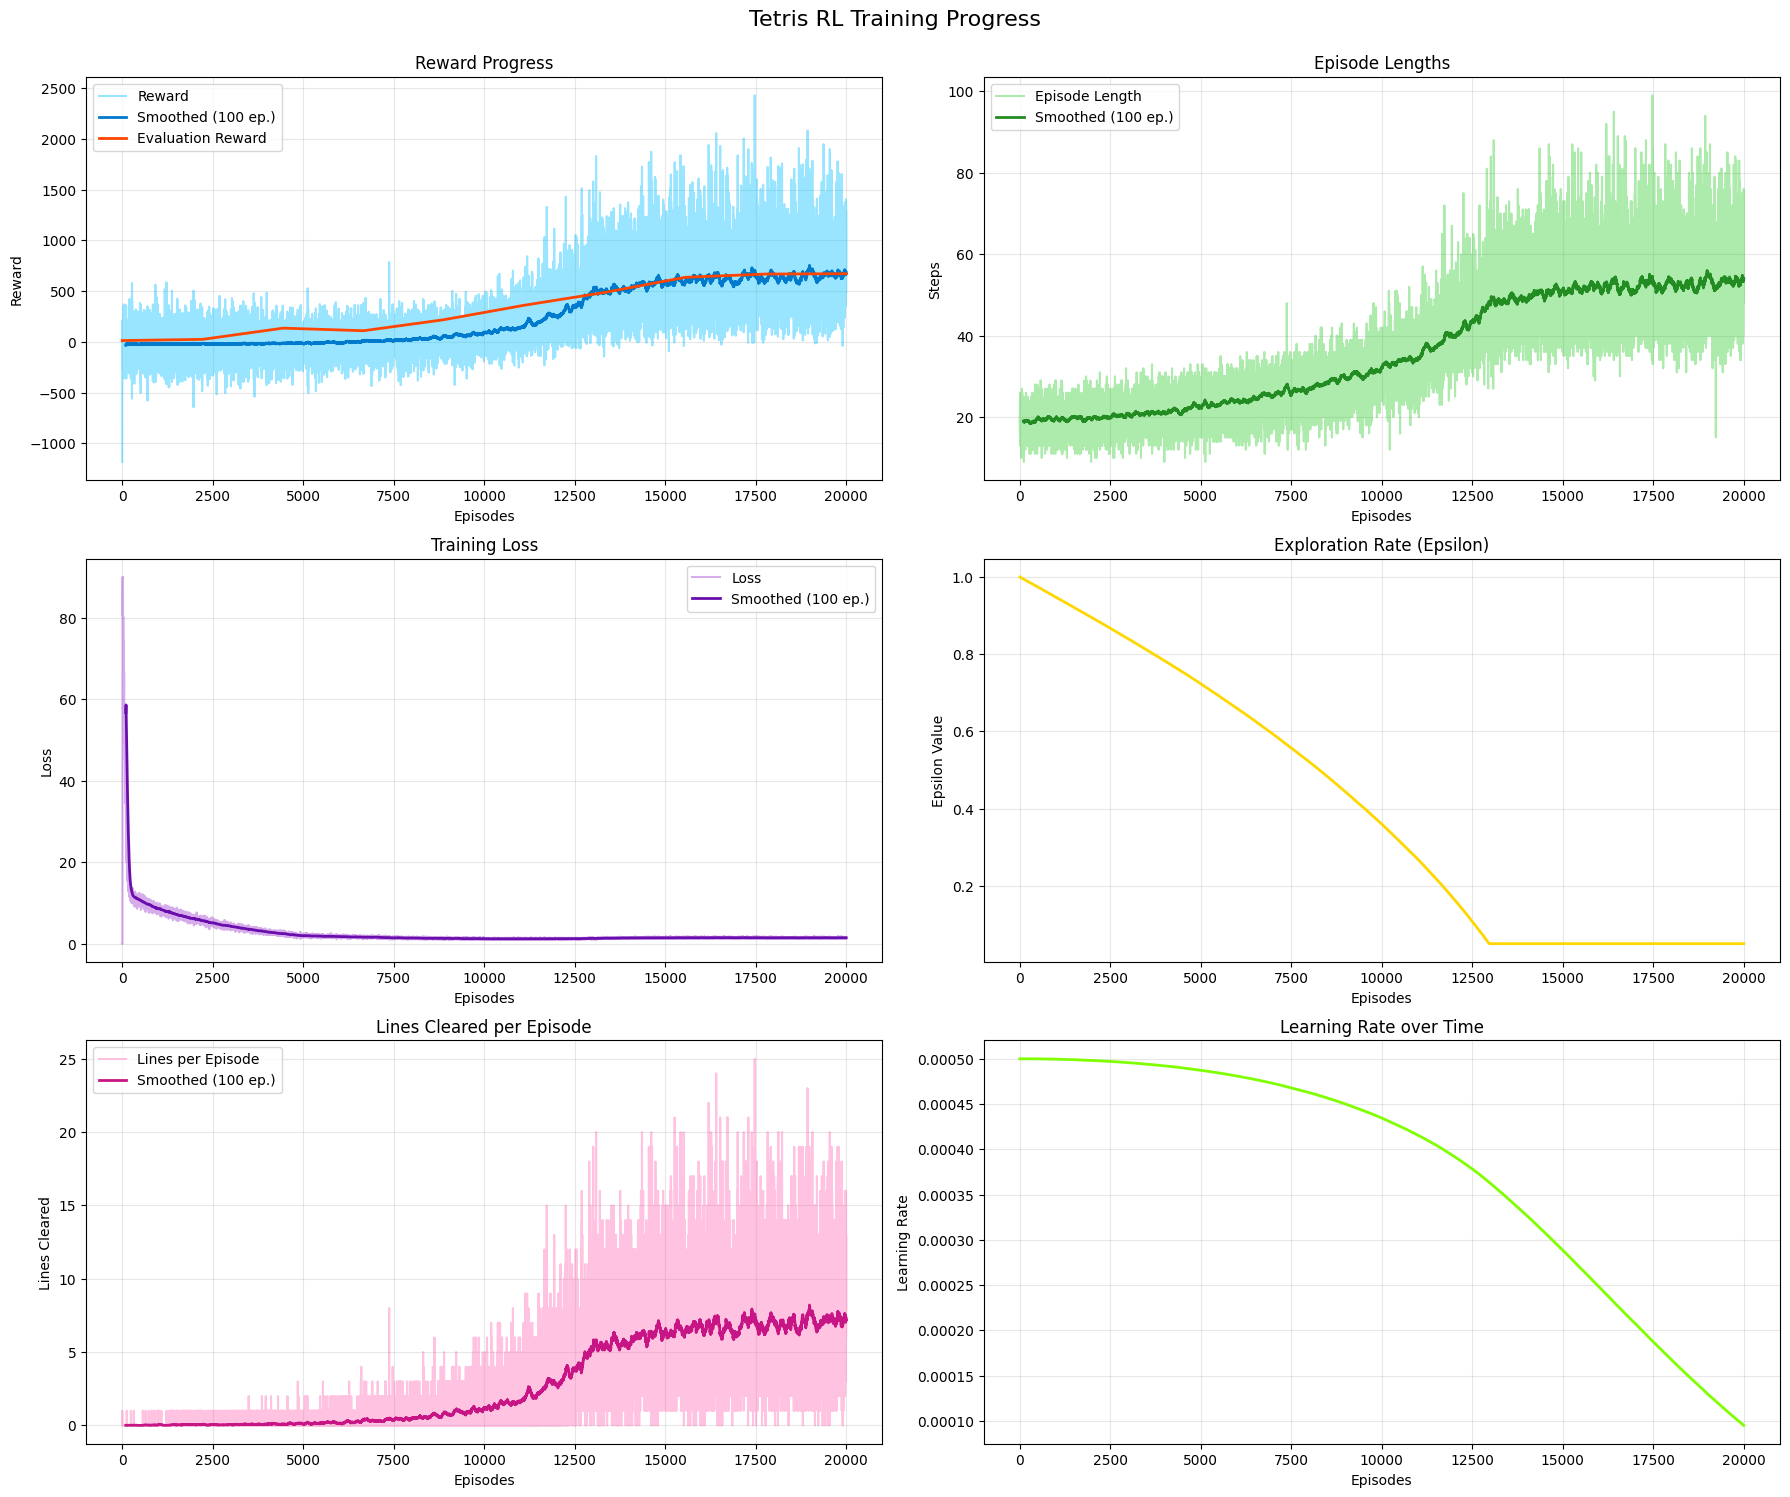

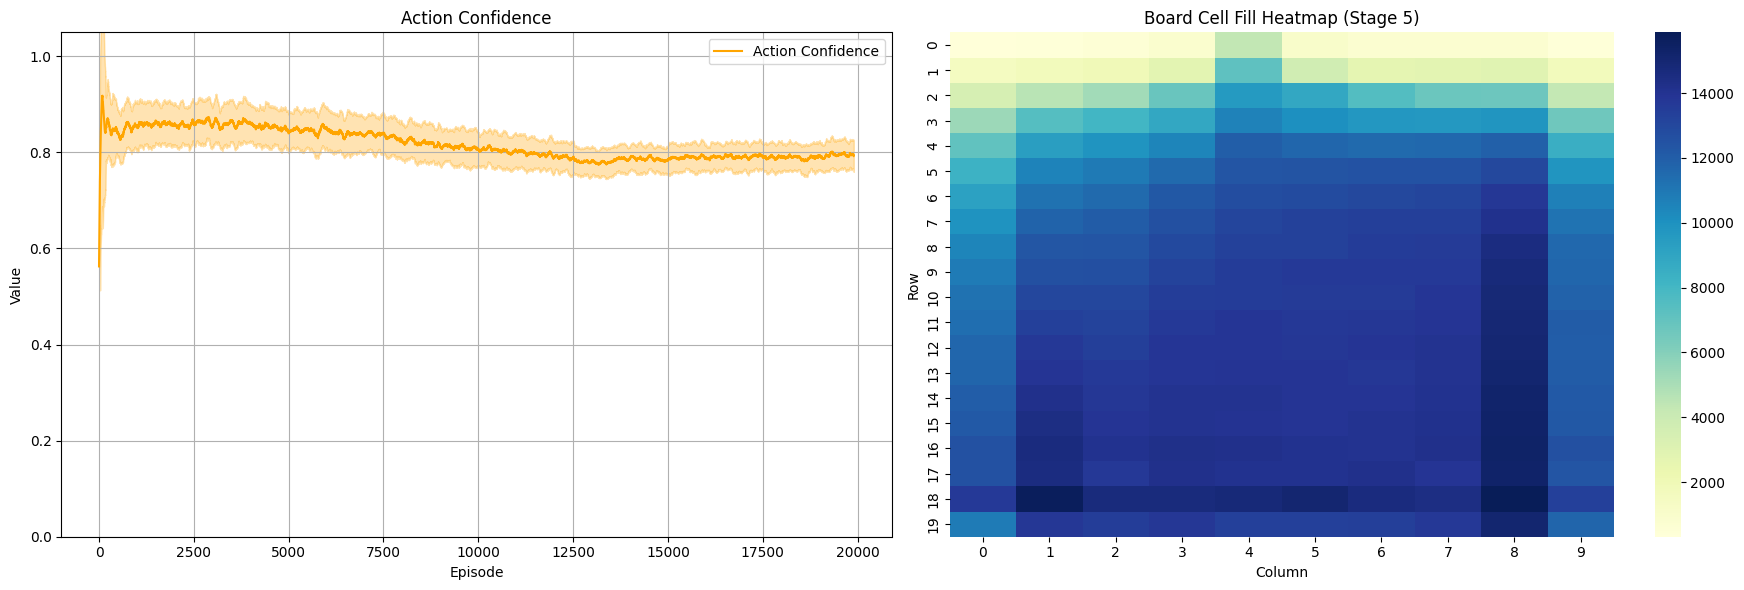


Final evaluation for this stage:

Initializing stage 5 with board size: 10×20
Updated field dimensions from 10×20 to 10×20
After set_field_dimensions, FIELD_W=10, FIELD_H=20
App dimensions: 10×20

Evaluating agent over 3 episodes...
  Episode 1/3: reward = 53.10, steps = 62, lines = 10
  Episode 2/3: reward = 1223.65, steps = 74, lines = 15
  Episode 3/3: reward = 235.10, steps = 43, lines = 2

Evaluation results:
  Average reward: 503.95
  Average steps: 59.7
  Average lines cleared: 9.0

Analyzing agent's decision patterns for stage 5...
  Episode 1/3 completed: 62 steps
  Episode 2/3 completed: 59 steps
  Episode 3/3 completed: 66 steps
Total actions analyzed: 187

Displaying agent decision distribution...


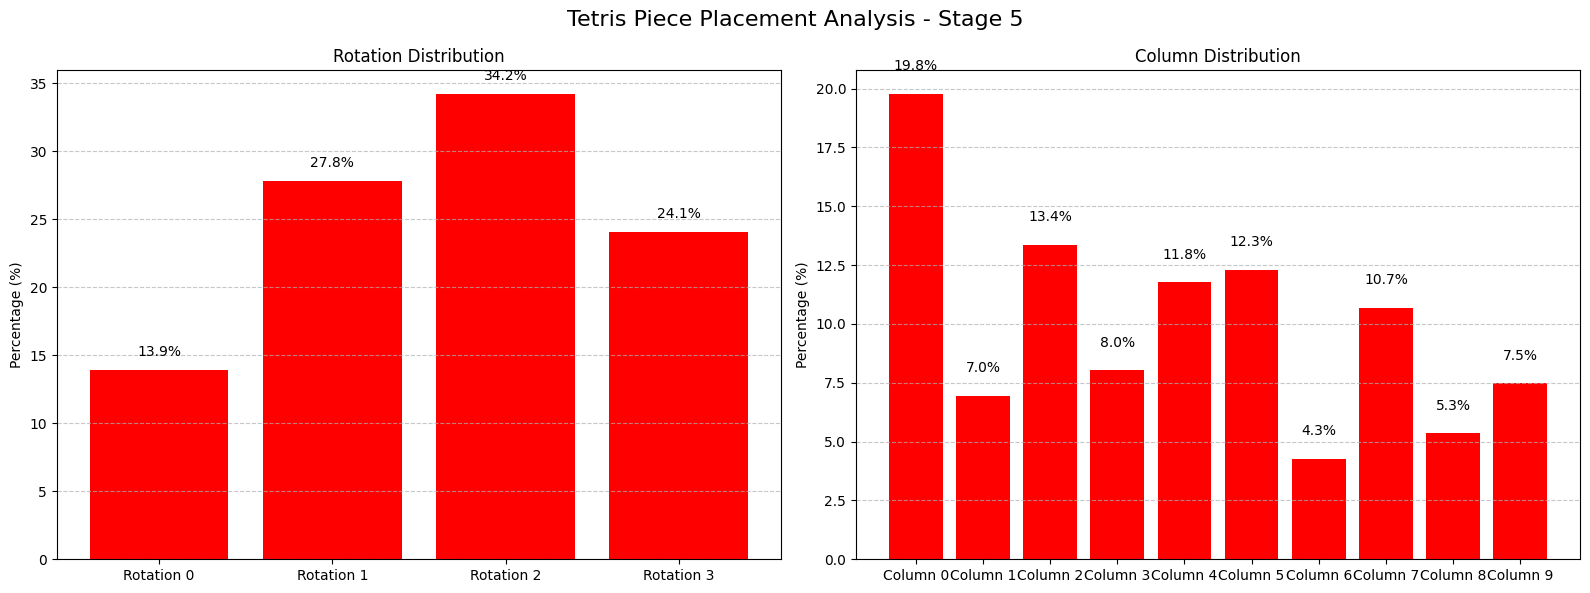


Demonstrating the trained agent on the full board:

Initializing stage 5 with board size: 10×20
Updated field dimensions from 10×20 to 10×20
After set_field_dimensions, FIELD_W=10, FIELD_H=20
App dimensions: 10×20

Demo game 1:

Evaluating agent over 1 episodes...
  Episode 1/1: reward = -703.90, steps = 40, lines = 2

Evaluation results:
  Average reward: -703.90
  Average steps: 40.0
  Average lines cleared: 2.0
Reward: -703.90

Demo game 2:

Evaluating agent over 1 episodes...
  Episode 1/1: reward = 664.84, steps = 54, lines = 8

Evaluation results:
  Average reward: 664.84
  Average steps: 54.0
  Average lines cleared: 8.0
Reward: 664.84

Demo game 3:

Evaluating agent over 1 episodes...
  Episode 1/1: reward = 1026.17, steps = 63, lines = 11

Evaluation results:
  Average reward: 1026.17
  Average steps: 63.0
  Average lines cleared: 11.0
Reward: 1026.17

Analyzing agent's decision patterns...
  Episode 1/5 completed: 54 steps
  Episode 2/5 completed: 67 steps
  Episode 3/5 comp

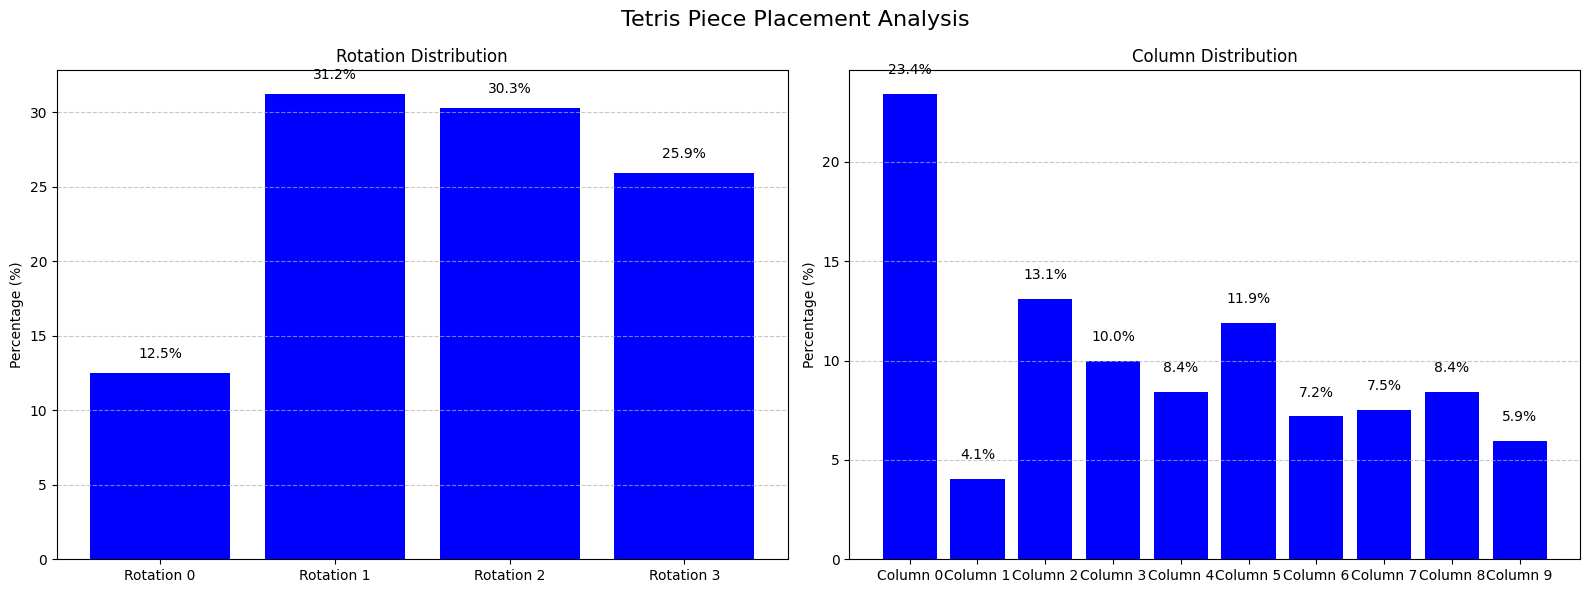


Training process completed successfully!


In [22]:
def main():
    """
    Main execution function – runs the full training process
    """
    print("Starting training of reinforcement learning agent for Tetris")

    # Set random seed for reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Create environment to determine input size
    temp_env = TetrisWrapper(render_mode=None, stage=5)
    sample_state = temp_env.reset()[0]
    input_size = len(sample_state)
    action_size = len(temp_env.action_space)
    temp_env.close()

    # Staged training
    trained_agents, training_metrics = staged_training(
        stages=(5,),
        episodes_per_stage=20_000,
        transfer_learning=True,
        input_size=input_size,
        action_size=action_size
    )

    # Demonstrate the trained agent on the full-size board
    print("\nDemonstrating the trained agent on the full board:")
    final_env = TetrisWrapper(render_mode="human", stage=5)
    final_agent = trained_agents[5]

    for i in range(3):
        print(f"\nDemo game {i+1}:")
        reward = evaluate_agent(final_env, final_agent, num_episodes=1, render=True, verbose=True)
        print(f"Reward: {reward:.2f}")

    print("\nAnalyzing agent's decision patterns...")
    analyze_agent_decisions(final_agent, final_env, episodes=5)

    final_env.close()
    print("\nTraining process completed successfully!")
    return trained_agents, training_metrics

if __name__ == "__main__":
    trained_agents, training_metrics = main()

<div dir = rtl>


# (10) צפייה בסוכן

In [42]:
def watch_agent_play_gif(model_path, output_name_base="tetris_ep", episodes=5, stage=5, fps=3):
    """
    Runs multiple games of a trained agent on Tetris, saving GIFs only for episodes
    where the agent breaks at least 20 lines.
    """
    env = TetrisWrapper(render_mode=None, stage=stage)

    # Get input/output dimensions from dummy run
    sample_state, _ = env.reset()
    temp_agent = DQNAgent(input_size=1, n_actions=1)
    input_size = temp_agent.preprocess_state(sample_state).shape[1]
    action_size = len(env.action_space)

    agent = DQNAgent(input_size=input_size, n_actions=action_size)
    agent.load_model(model_path)
    agent.policy_net.eval()

    shape_colors = {
        'I': (0, 255, 255), 'O': (255, 255, 0), 'T': (128, 0, 128),
        'S': (0, 255, 0), 'Z': (255, 0, 0), 'J': (0, 0, 255),
        'L': (255, 165, 0), 'default': (200, 200, 200)
    }

    for episode in range(episodes):
        frames = []
        state, _ = env.reset()
        done = False
        step = 0
        lines_in_episode = 0

        print(f"\n Running Episode {episode + 1}...")

        while not done:
            action = agent.select_action(state, eval_mode=True)
            state, reward, done, _, info = env.step(action)

            board_image = env.render_board_as_image()
            h, w, _ = board_image.shape

            fig, ax = plt.subplots(figsize=(7, 8))
            ax.imshow(board_image)

            lines_this_step = info.get('lines_cleared', 0)
            lines_in_episode += lines_this_step
            score = info.get('score', 0)

            ax.set_title(f"Step {step + 1} | Score: {score} | Lines: {lines_in_episode}", fontsize=12)
            ax.set_xticks(np.arange(-0.5, w, 1), minor=True)
            ax.set_yticks(np.arange(-0.5, h, 1), minor=True)
            ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
            ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

            # Preview next piece
            next_shape = getattr(env.tetris.next_tetromino, 'shape', None)
            if next_shape in TETROMINOES:
                shape_matrix = np.atleast_2d(TETROMINOES[next_shape][0])
                color = np.array(shape_colors.get(next_shape, shape_colors['default'])) / 255.0
                preview_x, preview_y = w + 1, 2

                for y, row in enumerate(shape_matrix):
                    for x, cell in enumerate(row):
                        if cell:
                            ax.add_patch(plt.Rectangle((preview_x + x, preview_y + y), 1, 1, color=color, ec='black'))
                ax.text(preview_x, preview_y - 1.5, f"Next: {next_shape}", fontsize=10)

            fig.canvas.draw()
            canvas = fig.canvas
            image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape(canvas.get_width_height()[::-1] + (4,))
            image = image[..., :3]
            frames.append(image)

            plt.close(fig)
            step += 1

        # Save only if lines broken exceed threshold
        if lines_in_episode >= 25:
            gif_name = f"{output_name_base}_ep{episode+1}.gif"
            gif_path = f"/content/drive/My Drive/tetris_game/gif/{gif_name}"
            imageio.mimsave(gif_path, frames, fps=fps)
            print(f"✅ Saved Episode {episode + 1} with {lines_in_episode} lines → {gif_path}")
            display(HTML(f'<img src="{gif_path}" autoplay loop>'))
        else:
            print(f"❌ Skipped Episode {episode + 1}: only {lines_in_episode} lines broken.")

In [43]:
watch_agent_play_gif(
    model_path="models/stage_5/best_model.pt",
    episodes=25,
    stage=5,
    fps=3
)


Initializing stage 5 with board size: 10×20
Updated field dimensions from 10×20 to 10×20
After set_field_dimensions, FIELD_W=10, FIELD_H=20
App dimensions: 10×20

 Running Episode 1...


<ipython-input-13-9cfc504eb742>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=(self.device == 'cuda'))


❌ Skipped Episode 1: only 3 lines broken.

 Running Episode 2...
❌ Skipped Episode 2: only 4 lines broken.

 Running Episode 3...
❌ Skipped Episode 3: only 15 lines broken.

 Running Episode 4...
❌ Skipped Episode 4: only 7 lines broken.

 Running Episode 5...
❌ Skipped Episode 5: only 10 lines broken.

 Running Episode 6...
❌ Skipped Episode 6: only 9 lines broken.

 Running Episode 7...
❌ Skipped Episode 7: only 13 lines broken.

 Running Episode 8...
❌ Skipped Episode 8: only 13 lines broken.

 Running Episode 9...
❌ Skipped Episode 9: only 5 lines broken.

 Running Episode 10...
❌ Skipped Episode 10: only 5 lines broken.

 Running Episode 11...
❌ Skipped Episode 11: only 5 lines broken.

 Running Episode 12...
❌ Skipped Episode 12: only 13 lines broken.

 Running Episode 13...
❌ Skipped Episode 13: only 8 lines broken.

 Running Episode 14...
❌ Skipped Episode 14: only 7 lines broken.

 Running Episode 15...
❌ Skipped Episode 15: only 6 lines broken.

 Running Episode 16...
❌ Skipp